### IMPORTS

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, wilcoxon, linregress, pearsonr
from sklearn.decomposition import PCA
from skbio.stats.distance import permanova
from scipy.spatial.distance import pdist, squareform
from skbio import DistanceMatrix
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from tqdm import tqdm

from pandas.plotting import table
from copy import deepcopy

from matplotlib.patches import Ellipse

import mne
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter


### PLOTTING CONFIGURATION

In [33]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

matplot_colors = ["C{}".format(i) for i in range(20)]

### UTILITY FUNCTIONS

In [34]:
def get_subject_list(output_dir):
    """Get sorted list of subject IDs from output directory."""
    subjects = [d[:4] for d in os.listdir(output_dir) if d[:4] != '.DS_']
    return sorted(set(subjects))

def load_info_csv(info_file):
    """Load subject information CSV."""
    return pd.read_csv(info_file, delimiter=';')

def remove_parentheses(region_name):
    """Remove content within parentheses from a region name."""
    start_idx = region_name.find('(')
    if start_idx != -1:
        # Remove content within parentheses
        return region_name[:start_idx].strip() + region_name[start_idx+1:].strip()
    return region_name

def df_transposing(df, transpose=False, region_initials=False):
    """Transpose DataFrame and optionally replace region names with initials."""
    region_list = df['region'].tolist()

    if region_initials:
        # Create region initials and remove parentheses
        df['region_initial'] = df['region'].apply(lambda x: ''.join([word[0] for word in x.split()]) +
                                                  ('_lh' if '-lh' in x else ('_rh' if '-rh' in x else '')))
        df['region_initial'] = df['region_initial'].apply(remove_parentheses)

        # Update region list and DataFrame
        region_list = [df['region'].tolist(), df['region_initial'].tolist()]
        df['region'] = df['region_initial']
        df.drop(columns=['region_initial'], inplace=True)

    # Transpose DataFrame
    df.set_index('region', inplace=True)
    if transpose==True:
        df = df.T
    return df, region_list

def load_data_csv(parc, mode, subjects_list, output_dir, df_info, transpose=False):
    """Load and process CSV data for subjects, adding relevant metadata."""
    dfs = []
    for subject in subjects_list:
        for ses in ['ses1', 'ses2']:
            subject_dir = os.path.join(output_dir, f"{subject}_output_{ses}")
            subject_filename = os.path.join(subject_dir, f"{subject}_{ses}_{parc}_{mode}.csv")
            if 'no_PCA_clean_RNN-zscore' in mode:
                df_subject = pd.read_csv(subject_filename)[['region', 'sigma_test0']]
                df_subject.rename(columns={'sigma_test0': 'sigma'}, inplace=True)
            else:
                df_subject = pd.read_csv(subject_filename)[['region', 'sigma_test']]
                df_subject.rename(columns={'sigma_test': 'sigma'}, inplace=True)

            # Transpose DataFrame and update region names
            df_subject, region_list = df_transposing(df_subject, transpose=transpose, region_initials=True)

            # Extract subject metadata
            subject_info = df_info[df_info['MEG_ID'] == int(subject)].iloc[0]
            health, updrs_on, updrs_off, age, hand, sex = subject_info['Sub_type'], subject_info['UPDRS_on'], subject_info['UPDRS_off'], subject_info['age'], subject_info['hand'], subject_info['sex']

            # Add metadata to DataFrame
            df_subject['group'] = health
            df_subject['session'] = ses
            df_subject['subject'] = int(subject)
            df_subject['age'] = age
            df_subject['hand'] = 0 if hand=='right' else 1
            df_subject['sex'] = 0 if sex=='M' else 1
            df_subject['UPDRS'] = updrs_on if health == 'patient' and ses == 'ses2' else updrs_off
            df_subject['medication'] = 'OFF' if health == 'patient' and ses == 'ses1' else 'ON' if health == 'patient' else 'no_medication'

            dfs.append(df_subject)

    # Concatenate all DataFrames
    df = pd.concat(dfs, axis=0)
    return region_list, df

def perform_statistical_tests_surrogate(data, data_surrogate, analysis_type='region'):    
    # Perform statistical tests for each brain region
    results_dict_surrogate = {}
    data_keys = list(data_surrogate.keys())
    
    # Iterate over pairs of groups
    for data_keys_ in data_keys:
        group1, group2 = data_keys_, data_keys_
        results = {}
        data_ = data[group1]
        data_surrogate_ = data_surrogate[group2]
        # Iterate over brain regions, skipping non-region columns
        if analysis_type=='subject':
            iteration_over = data_['subject'].unique()
        else:
            iteration_over = data[group1].columns[:-8]
        for iter_ in iteration_over:
            if analysis_type=='subject':
                data_type = data_[data_['subject']==iter_].iloc[:,1:-8].T
                data_surrogate_type = data_surrogate_[data_surrogate_['subject']==iter_].iloc[:,1:-8].T
            else: 
                data_type = data_[iter_]
                data_surrogate_type = data_surrogate_[iter_]
            # Perform t-test and Wilcoxon test
            statistic, p_value = wilcoxon(data_type, data_surrogate_type)
    
            # Store results
            results[iter_] = {
                'statistic': statistic,
                'p_value': p_value
            }
    
        # Convert results to a DataFrame and store in results_dict
        results_df_surrogate = pd.DataFrame(results).T
        results_dict_surrogate[group1] = results_df_surrogate

    return results_dict_surrogate
    
    # Now `results_dict` contains the statistical test results for each pair of groups
    

def perform_statistical_tests(data, test_list, test_type='', n_permutations=1000): #accepted_regions = df.columns[:-8]
    """
    Perform statistical tests for each brain region across different groups.

    Parameters:
    - df: DataFrame containing the data with columns for 'group', 'session', and brain regions.
    - test_type: Type of test to perform ('mannwhitney' or 'permutation').
    - n_permutations: Number of permutations for the permutation test.

    Returns:
    - results_dict: Dictionary containing the statistical test results for each pair of groups.
    """
    # Initialize results dictionary
    results_dict = {}
    data_keys = list(data.keys())

    # Iterate over pairs of groups
    for test_ in test_list:
        group1, group2 = test_
        results = {}

        # Iterate over brain regions, skipping non-region columns
        for region in tqdm(data[group1].columns[:-8], desc=f"Processing {test_[0] + ' vs ' + test_[1]}"):
            values1 = data[group1][region]
            values2 = data[group2][region]

            if test_type == 'permutation':
                # Perform permutation test
                observed_diff = np.mean(values1) - np.mean(values2)
                permuted_diffs = np.zeros(n_permutations)

                # Concatenate data for permutation
                combined_data = pd.concat([values1, values2])
                combined_labels = np.array([0] * len(values1) + [1] * len(values2))

                for i in range(n_permutations):
                    # Permute group labels
                    permuted_labels = np.random.permutation(combined_labels)
                    permuted_group1 = combined_data[permuted_labels == 0]
                    permuted_group2 = combined_data[permuted_labels == 1]
                    permuted_diffs[i] = np.mean(permuted_group1) - np.mean(permuted_group2)

                # Calculate p-value
                p_value = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))
                results[region] = {
                    'observed_diff': observed_diff,
                    'p_value': p_value
                }
            else:
                if test_type=='wilcoxon':
                    # Perform Wilcoxon test
                    stat, p_value = wilcoxon(values1, values2)
                else:
                    # Perform Mann-Whitney U test
                    stat, p_value = mannwhitneyu(values1, values2)
                results[region] = {
                    'stat': stat,
                    'p_value': p_value
                }

        # Convert results to a DataFrame and store in results_dict
        results_df = pd.DataFrame(results).T
        results_dict[f'{group1} vs {group2}'] = results_df

    return results_dict

# Example usage:
# results = perform_statistical_tests(df, test_type='permutation', n_permutations=10000)

def benjamini_hochberg(p_values, alpha=0.05):
    # Number of tests
    m = len(p_values)
    
    # Sort the p-values and keep track of their original indices
    sorted_indices = np.argsort(p_values)
    sorted_p_values = np.sort(p_values)
    
    # Compute the adjusted p-values
    adjusted_p_values = (sorted_p_values * m) / (np.arange(1, m + 1))
    
    # Ensure that the adjusted p-values are non-decreasing
    for i in range(m - 2, -1, -1):
        adjusted_p_values[i] = min(adjusted_p_values[i], adjusted_p_values[i + 1])
    
    # Reject the null hypothesis where the adjusted p-value <= alpha
    reject = adjusted_p_values <= alpha
    
    # Handle case when no p-values are rejected
    if np.any(reject):
        max_reject_index = np.max(np.where(reject)[0])
    else:
        max_reject_index = -1
    
    # Create the result array (True if reject, False if do not reject)
    result = np.zeros(m, dtype=bool)
    if max_reject_index >= 0:
        result[sorted_indices[:max_reject_index + 1]] = True
    
    # Return corrected p-values and the rejection decisions
    corrected_p_values = np.zeros(m)
    corrected_p_values[sorted_indices] = adjusted_p_values
    
    return result, corrected_p_values

def regress_out_age(df, region_cols, age_col=['age','hand','sex']):
    """
    Regress out age effects from brain region values.
    
    Parameters:
        df (pd.DataFrame): Input dataframe
        region_cols (list): List of brain region columns to adjust
        age_col (str): Name of age column
    
    Returns:
        pd.DataFrame: Copy of dataframe with age-regressed brain region values
    """
    df = df.copy()
    
    for region in region_cols:
        # Fit linear model: region_value ~ age
        X = sm.add_constant(df[age_col])  # Add intercept
        model = sm.OLS(df[region], X).fit()
        
        # Get predicted values based on age
        predicted = model.predict(X)
        
        # Compute residuals (age-regressed values)
        df[region] = df[region] - predicted + df[region].mean()  # Preserve original mean
    
    return df


### READ CSV

In [ ]:
data_dir = 'path_to_the_data_folder' # To fill
output_dir = os.path.join(data_dir, 'output')
subjects_list = get_subject_list(output_dir)
subjects_list.sort()

info_filename = os.path.join(data_dir, 'metadata_filename.csv') # To fill
df_info = pd.read_csv(info_filename, delimiter = ';')

parc = 'HCPMMP1_combined'
mode = 'no_PCA_clean_RNN-zscore'
region_list, df = load_data_csv(parc, mode, subjects_list, output_dir, df_info, transpose=True)

mode_surrogate = 'no_PCA_clean_RNN-zscore_surrogate'
region_list, df_surrogate = load_data_csv(parc, mode_surrogate, subjects_list, output_dir, df_info, transpose=True)

# Identify brain region columns (ending with _lh or _rh)
region_cols = [col for col in df.columns if col.endswith(('_lh', '_rh'))]

# Preprocess data and store in a dictionary
data = {
    'HC ses1': df[(df['group'] == 'control') & (df['session'] == 'ses1')],
    'HC ses2': df[(df['group'] == 'control') & (df['session'] == 'ses2')],
    'PD OFF': df[(df['group'] == 'patient') & (df['session'] == 'ses1')],
    'PD ON': df[(df['group'] == 'patient') & (df['session'] == 'ses2')]
}
data_keys = list(data.keys())

# Store data in a dictionary
data_surrogate = {
    'HC ses1': df_surrogate[(df_surrogate['group'] == 'control') & (df_surrogate['session'] == 'ses1')],
    'HC ses2': df_surrogate[(df_surrogate['group'] == 'control') & (df_surrogate['session'] == 'ses2')],
    'PD OFF': df_surrogate[(df_surrogate['group'] == 'patient') & (df_surrogate['session'] == 'ses1')],
    'PD ON': df_surrogate[(df_surrogate['group'] == 'patient') & (df_surrogate['session'] == 'ses2')]
}

group_to_num = {}
group_color = [3, 1, 0, 2]
group_list = ['HC ses1', 'HC ses2', 'PD OFF', 'PD ON']
for i,group_ in zip(group_color,group_list):
    group_to_num[group_] = i

# Saving figures here
save_figure_folder = 'path_to_the_figure_folder' # To fill
save_result_folder = os.path.join(save_figure_folder, 'result_plots')
save_supp_folder = os.path.join(save_figure_folder, 'supp_plots')
save_manuscript_folder = os.path.join(save_figure_folder, 'manuscript')
figsize = (7.5,4.5)

region_acronym_to_full = {region_list[1][k]:region_list[0][k] for k in range(len(region_list[0]))}
region_full_to_acronym = {region_list[0][k]:region_list[1][k] for k in range(len(region_list[0]))}

data['PD OFF']

In [ ]:
df_OFF = deepcopy(data['HC ses2'])
# Generate new index labels
new_index = [f'PwPD{i+1}' for i in range(len(df_OFF))]

# Assign the new index
df_OFF.index = new_index

# Alternative one-liner:
df_OFF.index = [f'PwPD{i+1}' for i in range(df_OFF.shape[0])]

df_OFF = df_OFF.iloc[:, :-8]
# Apply rounding to 3 significant figures
df_OFF = df_OFF.applymap(lambda x: f"{float(x):.2g}" if isinstance(x, (int, float)) else x)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')  # Hide axes

# Create table and auto-scale columns
tbl = table(ax, df_OFF.T, loc='center', cellLoc='center', colWidths=[0.08]*len(df_OFF.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)  # Adjust font size
tbl.scale(1.2, 1.2)   # Scale table size

# Save as PDF
plt.savefig(os.path.join(save_manuscript_folder, 'table_HC_ses2_EPR.pdf'), bbox_inches='tight')
plt.close()

# Statistical cleaning
Using surrogate data for performing Wilcoxon paired-tests in order to remove subjects and regions non-significantly different between original and surrogate data 

## Subject-wise testing

In [ ]:
results_dict_surrogate = perform_statistical_tests_surrogate(data, data_surrogate, analysis_type='subject')

# Create a single figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Combine unique subjects from 'HC ses1' and 'PD OFF'
subjects = data['HC ses1']['subject'].unique().tolist() + data['PD OFF']['subject'].unique().tolist()

# Iterate over data keys to plot p-values
for i, group in enumerate(data_keys):
    subjects_ = data[group]['subject'].unique()
    x_offset = len(data['HC ses1']['subject'].unique()) if i > 1 else 0  # Offset x-values for better visual separation
    plt.scatter(
        np.arange(len(subjects_)) + x_offset,
        results_dict_surrogate[group]['p_value'],
        label=group,
        color=matplot_colors[group_to_num[group]]
    )

# Add a horizontal line at y = 0.001 to indicate the p-value threshold
p_val_threshold = 0.001
plt.axhline(y=p_val_threshold, color='red', linestyle='-', linewidth=2, label=f'{p_val_threshold} threshold')

# Set x-ticks to include all subjects
plt.xticks(ticks=np.arange(len(subjects)), labels=subjects, rotation=90)
# Add labels and title
plt.ylabel('p-value')
plt.xlabel('subject id')
plt.title('Subject-wise Wilcoxon pair-tests between original and surrogate data')
# Place the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
# Adjust layout to ensure the legend doesn't overlap with the plot
plt.tight_layout()
# Set y-axis to log scale
ax.set_yscale('log')
ax.grid(False)
fig.savefig(os.path.join(save_manuscript_folder, 'subject-wise_surrogate_comparison.pdf'), bbox_inches='tight')
# Display the plot
plt.show()

In [ ]:
reject_subject = []
for i,group in enumerate(data_keys):
    # Extract p-values
    results_df = results_dict_surrogate[group]
    p_values = results_df['p_value']
    
    # Apply FDR correction
    reject, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh', alpha=p_val_threshold)
    
    # Add corrected p-values to the results DataFrame
    results_df['p_value_corrected'] = p_values_corrected
    results_df['reject_null'] = reject
    results_dict_surrogate[group] = results_df
    reject_subject.extend(data[group]['subject'][reject==False])

reject_subject = np.unique(reject_subject+[332])

for i,group in enumerate(data_keys):
    data[group] = data[group][~data[group]['subject'].isin(reject_subject)]
    data_surrogate[group] = data_surrogate[group][~data_surrogate[group]['subject'].isin(reject_subject)]

print(f'Subject {reject_subject} has been rejected in data and data_surrogate.')

## Region-wise testing

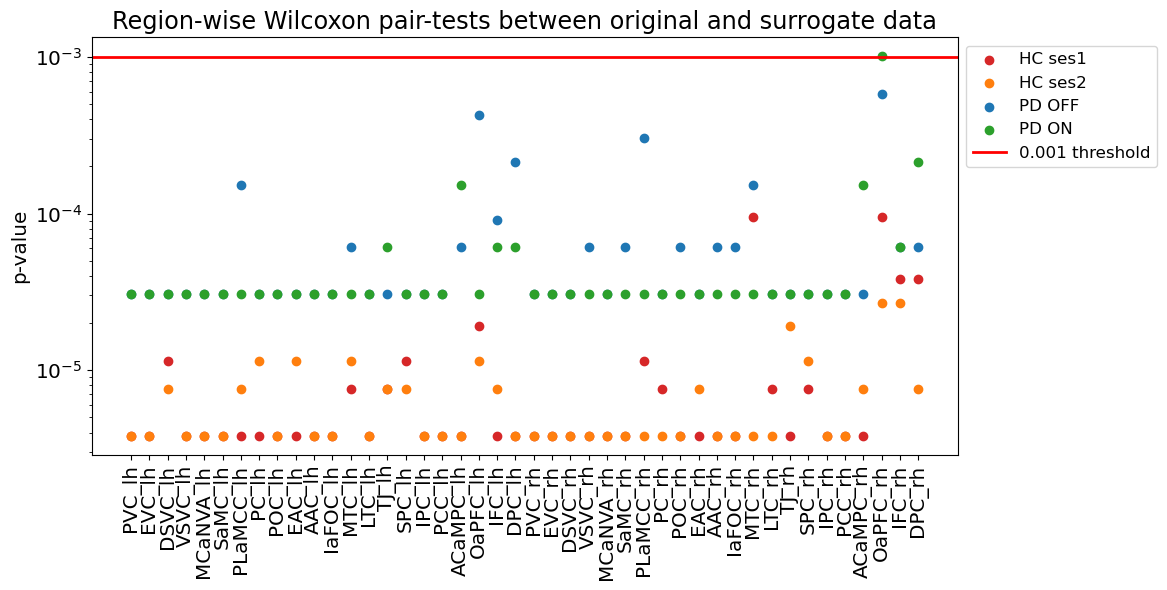

In [ ]:
results_dict_surrogate = perform_statistical_tests_surrogate(data, data_surrogate)

# Create a single figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

for i,group in enumerate(data_keys):
    plt.scatter(data[group].columns[:-8],results_dict_surrogate[group]['p_value'], label = group, color=matplot_colors[group_to_num[group]])

# Add a red horizontal line at y = 0.05
p_val_threshold = 0.001
plt.axhline(y=p_val_threshold, color='red', linestyle='-', linewidth=2, label = f'{p_val_threshold} threshold')
plt.xticks(rotation=90)
plt.legend()
plt.ylabel('p-value')
plt.title('Region-wise Wilcoxon pair-tests between original and surrogate data')
# Place the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
# Adjust layout to ensure the legend doesn't overlap with the plot
plt.tight_layout()
ax.set_yscale('log')
fig.savefig(os.path.join(save_manuscript_folder, 'region-wise_surrogate_comparison.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
reject_all = []
for i,group in enumerate(data_keys):
    # Extract p-values
    results_df = results_dict_surrogate[group]
    p_values = results_df['p_value']
    
    # Apply FDR correction
    reject, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh', alpha=p_val_threshold)
    
    # Add corrected p-values to the results DataFrame
    results_df['p_value_corrected'] = p_values_corrected
    results_df['reject_null'] = reject
    results_dict_surrogate[group] = results_df
    
    if i==0:
        reject_all = reject
    else:
        reject_all *= reject

print(f'{data[group].columns[:-8][reject_all==False]} regions have been rejected from data and data_surrogate.')

for i,group in enumerate(data_keys):
    columns_to_remove = data[group].columns[:-8][reject_all==False]
    data[group] = data[group].drop(columns=columns_to_remove)
    data_surrogate[group] = data_surrogate[group].drop(columns=columns_to_remove)


Index(['OaPFC_rh'], dtype='object', name='region') regions have been rejected from data and data_surrogate.


Processing HC ses1 vs HC ses2: 100%|███████████████| 43/43 [00:00<00:00, 948.52it/s]


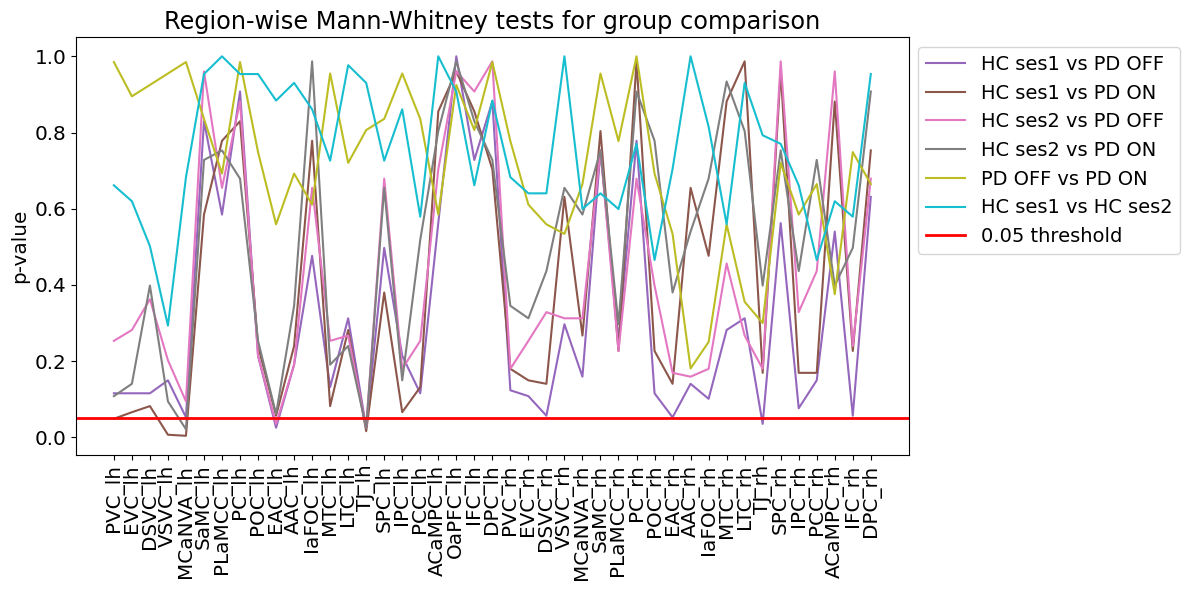

In [ ]:
test_list = [['HC ses1', 'PD OFF'], ['HC ses1', 'PD ON'], ['HC ses2', 'PD OFF'], ['HC ses2', 'PD ON'] , ['PD OFF', 'PD ON'], ['HC ses1', 'HC ses2']]
results_dict = perform_statistical_tests(data, test_list, test_type='mannwhitney')

fig, ax = plt.subplots(figsize=(12, 6))
for i,test_ in enumerate(test_list):
    group1 = test_[0]
    group2 = test_[1]
    results_df = results_dict[group1+' vs '+group2]
    region_x_axis = data[group].columns[:-8]
    plt.plot(region_x_axis,results_df['p_value'], label = group1+' vs '+group2, color=matplot_colors[4+i])

# Add a red horizontal line at y = 0.05
plt.axhline(y=0.05, color='red', linestyle='-', linewidth=2, label = '0.05 threshold')
plt.xticks(rotation=90)
plt.legend()
plt.ylabel('p-value')
plt.title('Region-wise Mann-Whitney tests for group comparison')
# Place the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
# Adjust layout to ensure the legend doesn't overlap with the plot
plt.tight_layout()
fig.savefig(os.path.join(save_manuscript_folder, 'Mann-Whitney_test_region_and_group-wise_comparison.pdf'), bbox_inches='tight')
plt.show()

In [44]:
print(f'{data[group].columns[:-8][results_df['p_value']<0.05]} regions have been rejected from data and data_surrogate.')
for i,group in enumerate(data_keys):
    columns_to_remove = data[group].columns[:-8][results_df['p_value']<0.05]
    data[group] = data[group].drop(columns=columns_to_remove)
    data_surrogate[group] = data_surrogate[group].drop(columns=columns_to_remove)

Index([], dtype='object', name='region') regions have been rejected from data and data_surrogate.


Processing HC ses1 vs HC ses2: 100%|███████████████| 43/43 [00:00<00:00, 576.34it/s]


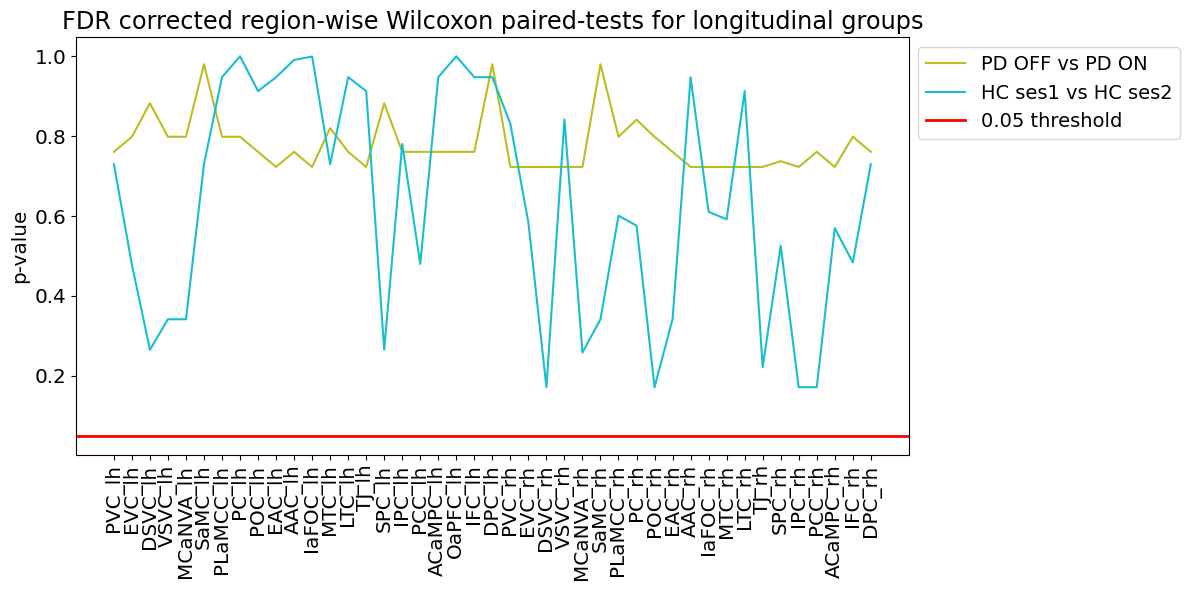

In [ ]:
test_list = [['PD OFF', 'PD ON'], ['HC ses1', 'HC ses2']]
results_dict = perform_statistical_tests(data, test_list, test_type='wilcoxon')

fig, ax = plt.subplots(figsize=(12, 6))
for i,test_ in enumerate(test_list):
    group1 = test_[0]
    group2 = test_[1]
    results_df = results_dict[group1+' vs '+group2]
    region_x_axis = data[group].columns[:-8]
    _,p_values = benjamini_hochberg(results_df['p_value'], alpha=0.05)
    plt.plot(region_x_axis, p_values, label = group1+' vs '+group2, color=matplot_colors[8+i])

# Add a red horizontal line at y = 0.05
plt.axhline(y=0.05, color='red', linestyle='-', linewidth=2, label = '0.05 threshold')
plt.xticks(rotation=90)
plt.legend()
plt.ylabel('p-value')
plt.title('FDR corrected region-wise Wilcoxon paired-tests for longitudinal groups')# Place the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
# Adjust layout to ensure the legend doesn't overlap with the plot
plt.tight_layout()
fig.savefig(os.path.join(save_manuscript_folder, 'Wilcoxon_paired-test_region_and_group-wise_comparison.pdf'), bbox_inches='tight')
plt.show()

## Testing EPR differences using the multivariate test: permutation Multivariate-ANOVA

In [46]:
# Compute mean and std for each subject
data_mean = []
data_std = []
group_to_ind = {
    'HC ses1':0,
    'HC ses2':1,
    'PD OFF':2,
    'PD ON':3
}
for group in group_list:
    # Explicit column selection
    data_mean.append(data[group].iloc[:,:-8].mean(axis=1))
    data_std.append(data[group].iloc[:,:-8].std(axis=1))

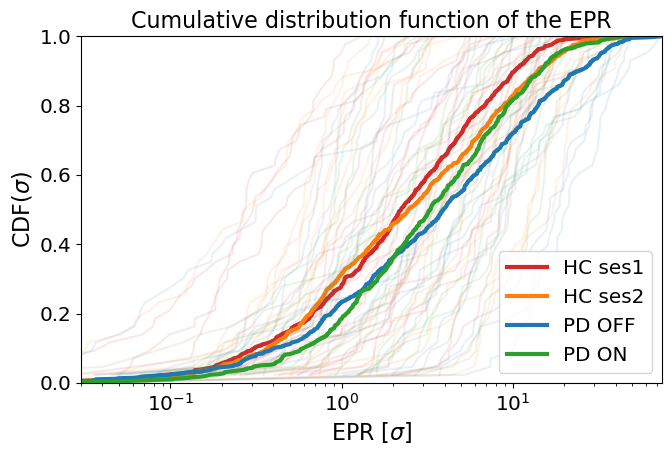

In [ ]:
def cdf_estimate(x):
    return (np.arange(len(x)) + 1)/len(x)

x_lim = (0.03,75)

fig, ax = plt.subplots(figsize=figsize)
for k,group in enumerate(group_list):
    data_ = np.array(data[group].iloc[:,:-8])
    sorted_data = np.sort(data_.flatten())
    plt.plot(sorted_data, cdf_estimate(sorted_data), linewidth=3, color=matplot_colors[group_to_num[group]], label=group )

    sorted_array = np.array([np.sort(data_[i,:]) for i in range(len(data_))])
    
    for sorted_data in sorted_array:
        if sorted_data[-1] == np.min(sorted_array[:,-1]):
            plt.plot(sorted_data.tolist()+[x_lim[1]], cdf_estimate(sorted_data).tolist()+[1], alpha=0.1, color=matplot_colors[group_to_num[group]])
        elif sorted_data[0] == np.max(sorted_array[:,0]):
            plt.plot([x_lim[0]]+sorted_data.tolist(), [0]+cdf_estimate(sorted_data).tolist(), alpha=0.1, color=matplot_colors[group_to_num[group]])
        else:
            plt.plot(sorted_data, cdf_estimate(sorted_data), alpha=0.1, color=matplot_colors[group_to_num[group]])


plt.title(r'Cumulative distribution function of the EPR', fontsize=16)
plt.xlabel(r'EPR [$\sigma$]', fontsize=16)
plt.ylabel(r'CDF($\sigma$)', fontsize=16)
ax.set_xscale('log')
plt.xlim(x_lim)
plt.ylim((0,1))
plt.legend(loc='lower right')
# Save the figure
fig.savefig(os.path.join(save_manuscript_folder, 'cdf_group_EPR_all_brain_region.pdf'), bbox_inches='tight')
plt.show()

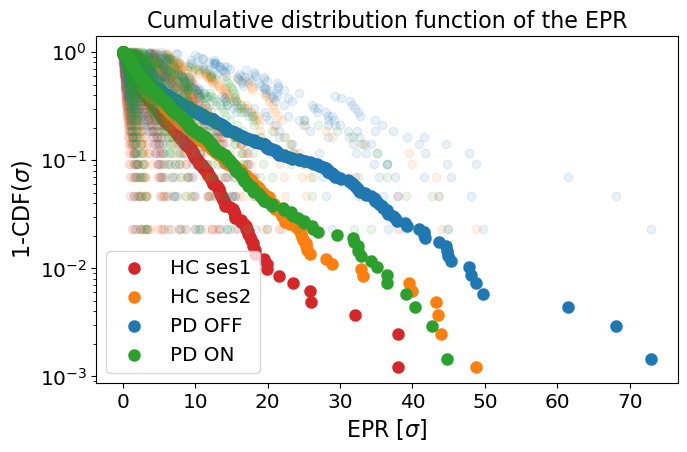

In [ ]:
def cdf_estimate(x):
    return (np.arange(len(x)) + 1)/len(x)

x_lim = (0.03,75)

fig, ax = plt.subplots(figsize=figsize)
for k,group in enumerate(group_list):
    data_ = np.array(data[group].iloc[:,:-8])
    sorted_data = np.sort(data_.flatten())[::-1]
    plt.scatter(sorted_data, cdf_estimate(sorted_data), linewidth=3, color=matplot_colors[group_to_num[group]], label=group )

    sorted_array = np.array([np.sort(data_[i,:])[::-1] for i in range(len(data_))])
    
    for sorted_data in sorted_array:
       plt.scatter(sorted_data, cdf_estimate(sorted_data), alpha=0.1, color=matplot_colors[group_to_num[group]])


plt.title(r'Cumulative distribution function of the EPR', fontsize=16)
plt.xlabel(r'EPR [$\sigma$]', fontsize=16)
plt.ylabel(r'1-CDF($\sigma$)', fontsize=16)
ax.set_yscale('log')
plt.legend(loc='lower left')
# Save the figure
fig.savefig(os.path.join(save_manuscript_folder, 'cdf_tail_group_EPR_all_brain_region.pdf'), bbox_inches='tight')
plt.show()

In [18]:
p_val_tests = []
test_list = [['HC ses1', 'PD OFF'], ['HC ses1', 'PD ON'], ['HC ses2', 'PD OFF'], ['HC ses2', 'PD ON'] , ['PD OFF', 'PD ON'], ['HC ses1', 'HC ses2']]
for test_ in test_list:
    controls = data[test_[0]].iloc[:,:-8]
    parkinsons = data[test_[1]].iloc[:,:-8]
    if test_ in [['HC ses1', 'HC ses2'], ['PD OFF', 'PD ON']]:
        stat, p_value = wilcoxon(data_mean[group_to_ind[test_[0]]], data_mean[group_to_ind[test_[1]]])
        result={'p-value':p_value}
        print(p_value)
    else:
        # Compute distance matrix (Euclidean)
        combined = np.vstack([controls, parkinsons])
        labels = np.array(["Control"]*len(controls) + ["Parkinson"]*len(parkinsons))
        dist_matrix = squareform(pdist(combined, metric="euclidean"))
        dm = DistanceMatrix(dist_matrix, ids=[f"subj_{i}" for i in range(len(combined))])
        # Run PERMANOVA
        result = permanova(dm, labels, permutations=200000)
        print(f"PERMANOVA pseudo-F: {result['test statistic']:.3f}, p = {result['p-value']:.4f}")
    p_val_tests.append(result['p-value'])


PERMANOVA pseudo-F: 3.631, p = 0.0197
PERMANOVA pseudo-F: 2.044, p = 0.0962
PERMANOVA pseudo-F: 1.998, p = 0.1092
PERMANOVA pseudo-F: 0.824, p = 0.4546
0.433197021484375
0.312408447265625


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC ses2 vs. PD OFF: Custom statistical test, P_val:1.092e-01
HC ses1 vs. PD OFF: Custom statistical test, P_val:1.971e-02
HC ses2 vs. PD ON: Custom statistical test, P_val:4.546e-01
HC ses1 vs. PD ON: Custom statistical test, P_val:9.623e-02


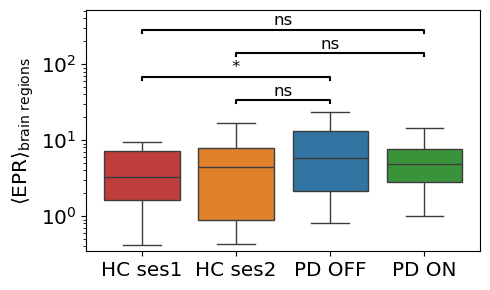

In [ ]:
# Prepare data for plotting
plot_data = []
for test in test_list:
    controls = np.array(data[test[0]].iloc[:, :-8]).mean(axis=1)
    parkinsons = np.array(data[test[1]].iloc[:, :-8]).mean(axis=1)

    # Store data for plotting
    plot_data.extend([{'Group': test[0], 'Value': val} for val in controls])
    plot_data.extend([{'Group': test[1], 'Value': val} for val in parkinsons])

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)
plot_df['Group'] = pd.Categorical(plot_df['Group'], categories=group_list, ordered=True)

# Create violin plot
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(x='Group', y='Value', hue='Group', data=plot_df,
               palette=[matplot_colors[group_to_num[group]] for group in group_list],
               #cut=0,
               legend=False, ax=ax)
ax.set_yscale('log')

# Annotation function
def add_annotations(pairs, p_values, color='black'):
    annotator = Annotator(ax, pairs, data=plot_df, x='Group', y='Value')
    annotator.configure(text_format='star', loc='inside', fontsize=12, color=color)
    annotator.set_pvalues(p_values)
    annotator.annotate()

# Add annotations
add_annotations([('HC ses2', 'PD OFF'), ('HC ses1', 'PD ON'), ('HC ses1', 'PD OFF'), ('HC ses2', 'PD ON')],
                [p_val_tests[k] for k in [2, 1, 0, 3]])

# Customize plot labels
ax.set_ylabel(r'$\langle$EPR$\rangle_{\text{brain regions}}$')
ax.set_xlabel('')
plt.tight_layout()

# Save the figure
fig.savefig(os.path.join(save_manuscript_folder, 'box_plot_all_regions_stats.pdf'), bbox_inches='tight')

# Show plot
plt.show()


## Testing EPR differences brain region-wise with a stringent test: Mann-Whitney

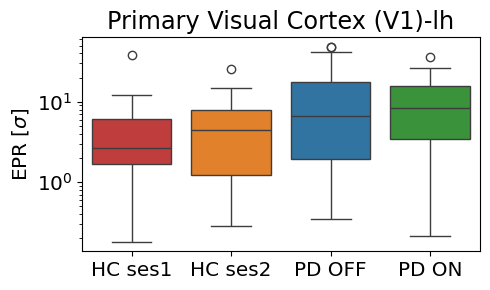

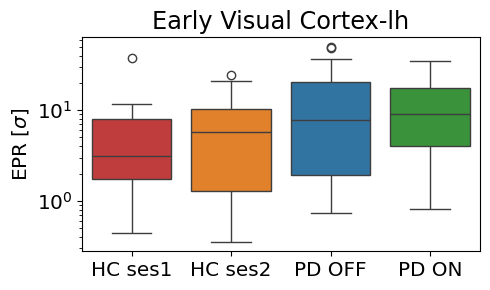

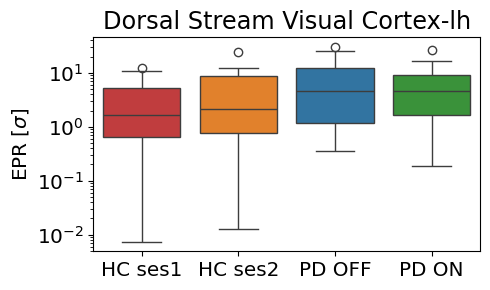

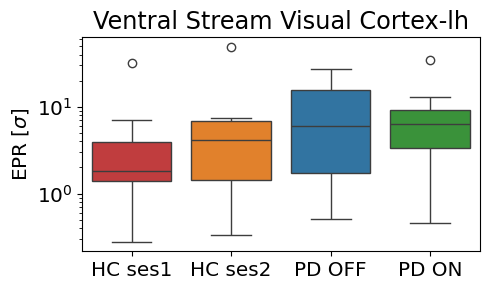

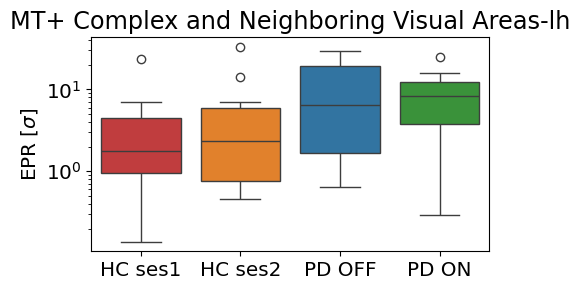

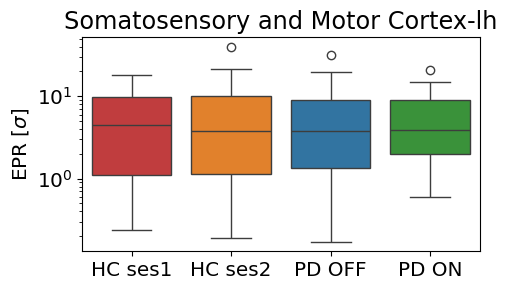

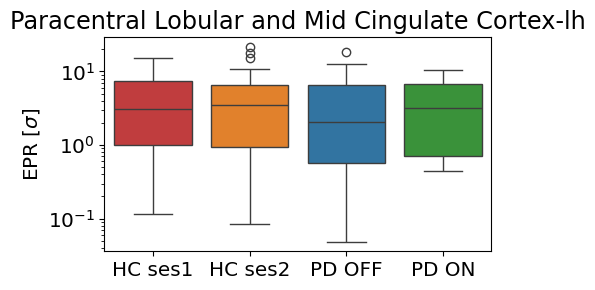

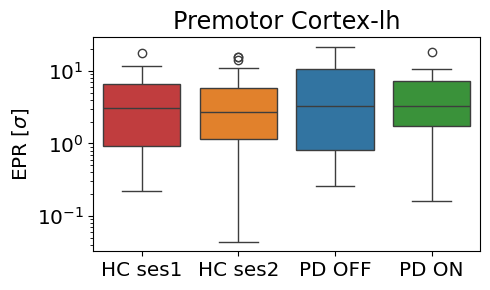

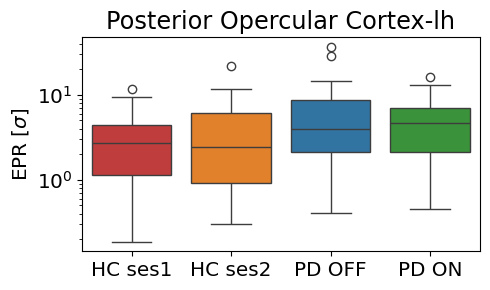

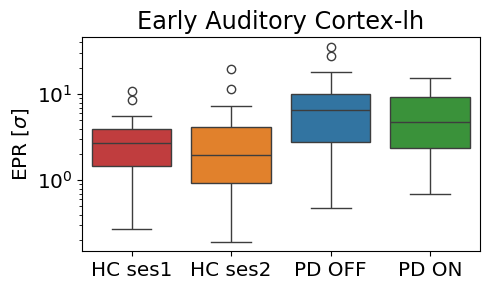

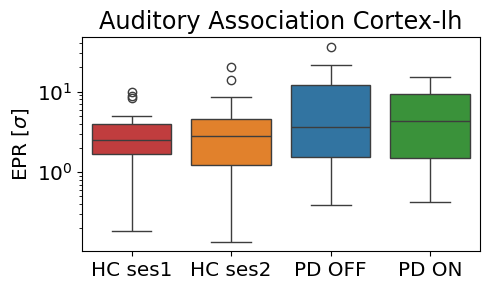

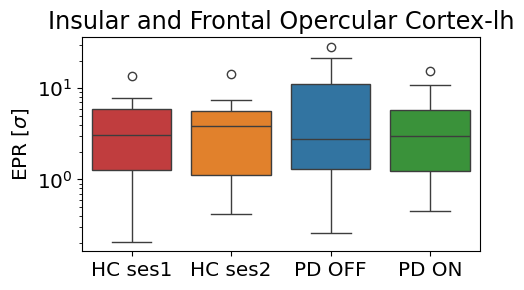

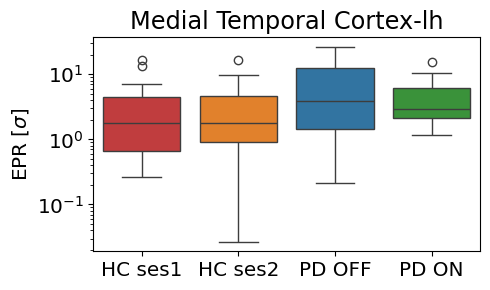

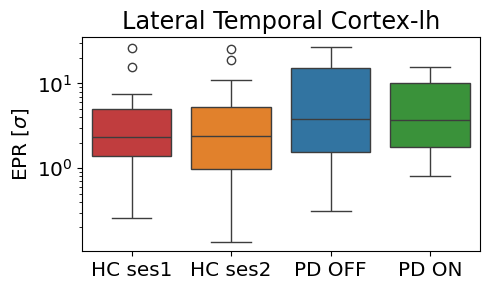

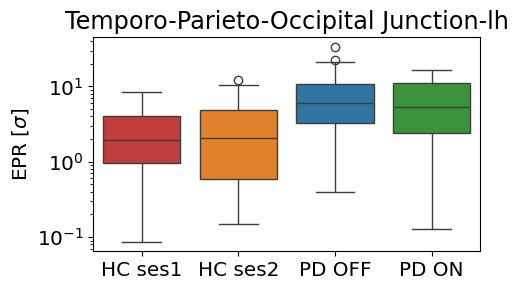

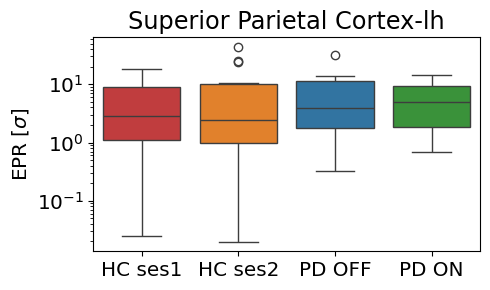

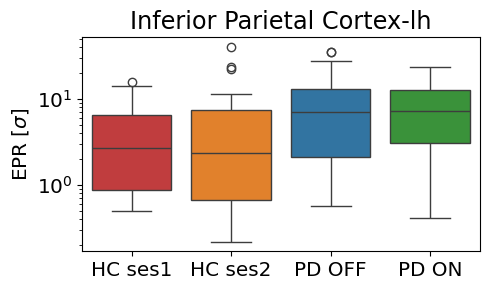

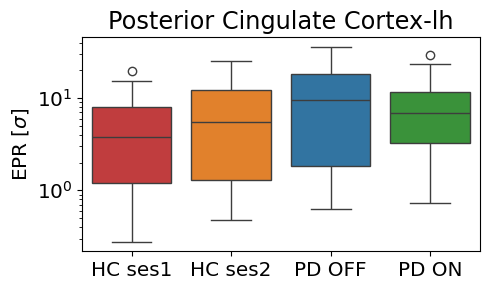

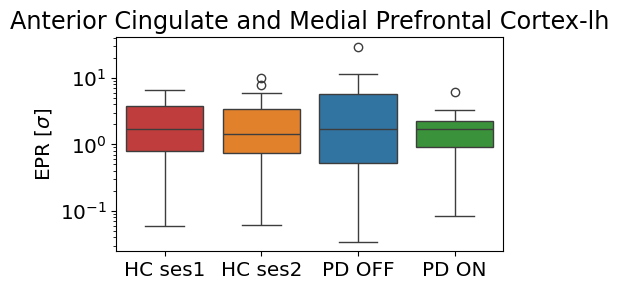

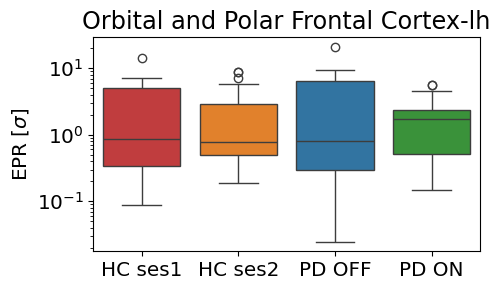

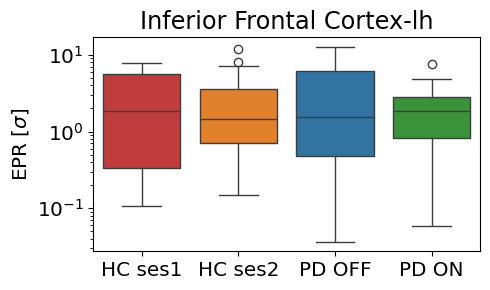

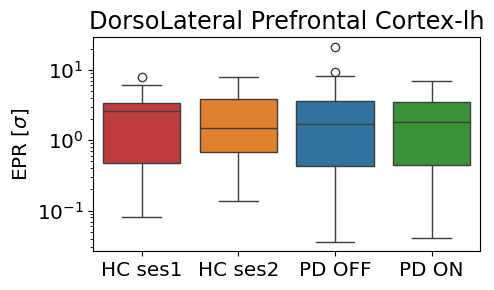

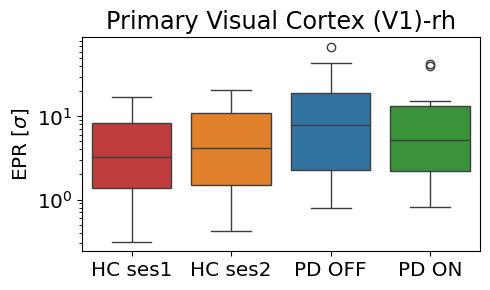

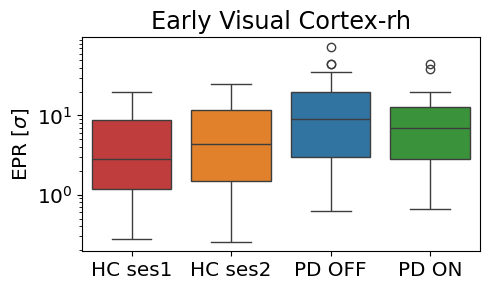

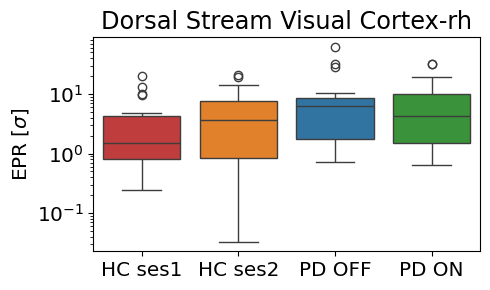

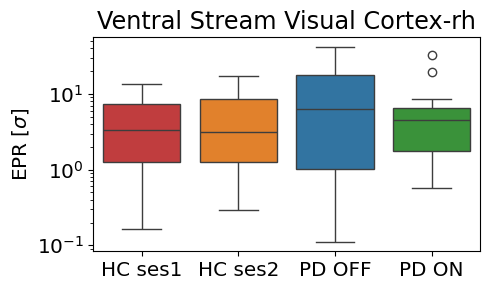

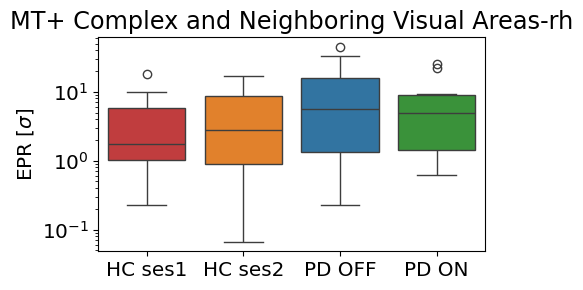

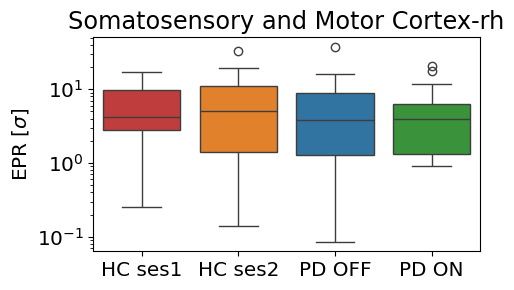

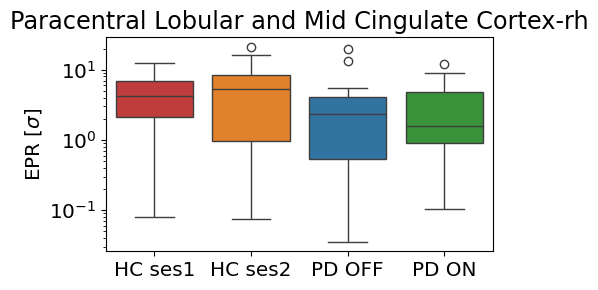

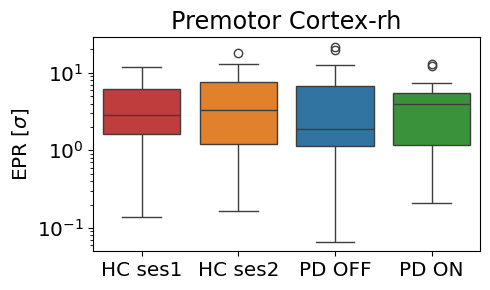

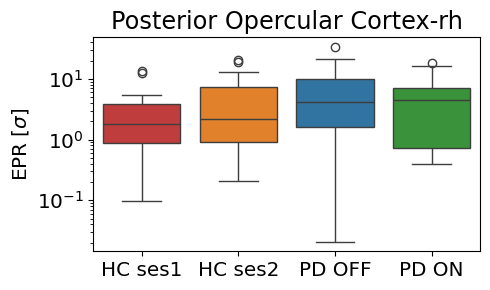

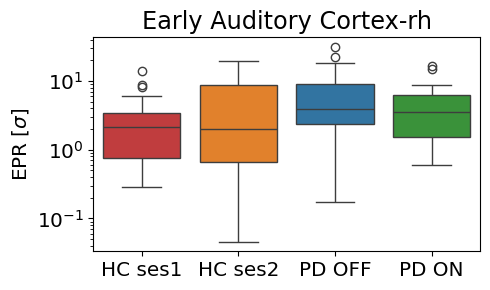

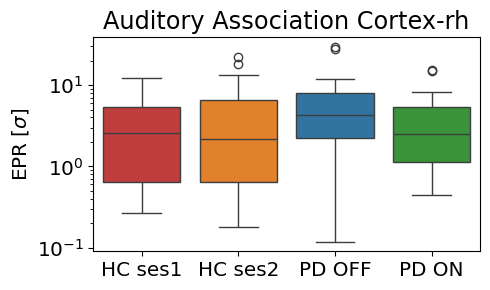

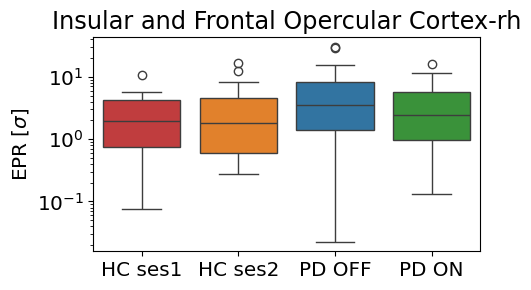

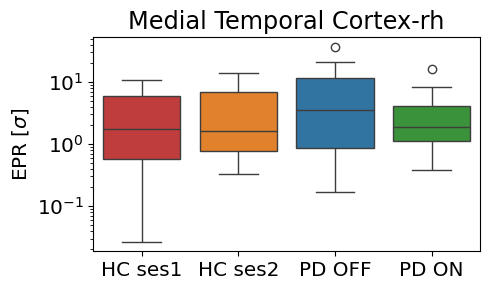

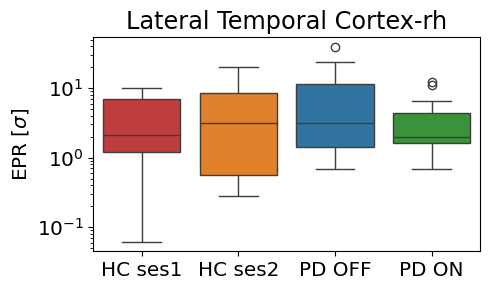

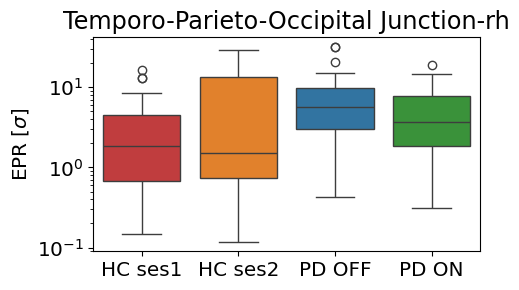

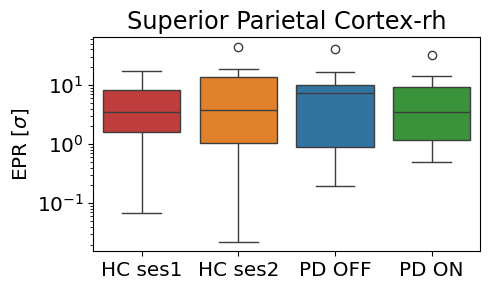

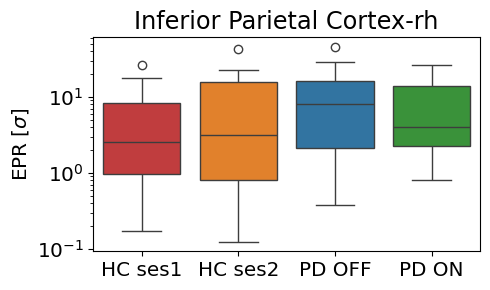

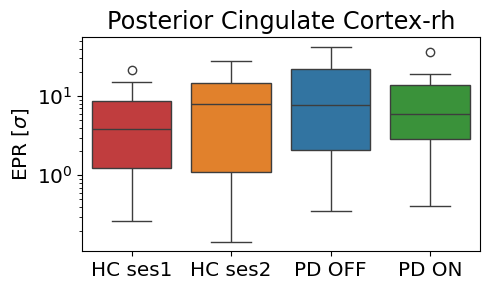

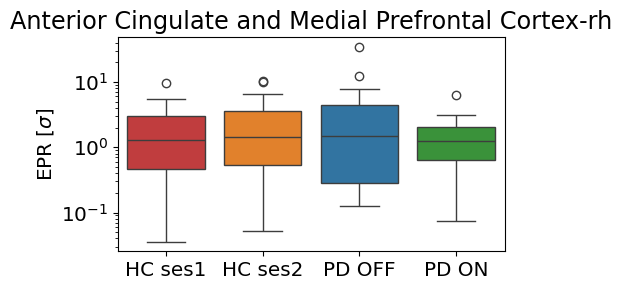

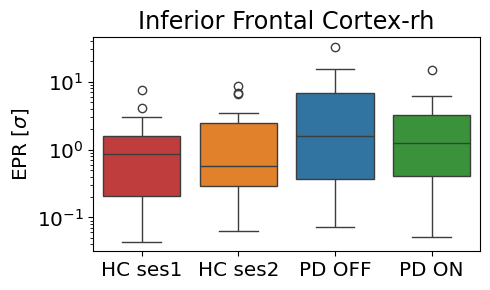

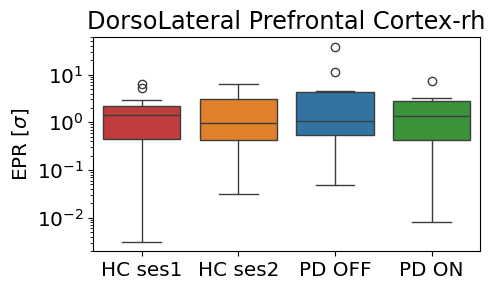

In [ ]:
for region in data['HC ses1'].columns[:-8]:
    # Prepare data for plotting
    plot_data = []
    for group in group_list:
        data_ = data[group][region]
        # Store data for plotting
        plot_data.extend([{'Group': group, 'Value': val} for val in data_])
    
    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)
    plot_df['Group'] = pd.Categorical(plot_df['Group'], categories=group_list, ordered=True)
    
    # Create violin plot
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x='Group', y='Value', hue='Group', data=plot_df,
                   palette=[matplot_colors[group_to_num[group]] for group in group_list],
                   #cut=0, 
                   legend=False, ax=ax)
    # Customize plot labels
    plt.title(region_acronym_to_full[region])
    ax.set_ylabel(r'EPR [$\sigma$]')
    ax.set_xlabel('')
    ax.set_yscale('log')
    plt.tight_layout()
    # Save the figure
    fig.savefig(os.path.join(save_manuscript_folder,'box_plots', f'box_plot_{region}.pdf'), bbox_inches='tight')
    # Show plot
    plt.show()

# EPR Statistics

In [17]:
# Compute mean and std for each subject
data_mean = []
data_std = []

for group in group_list:
    # Explicit column selection
    data_mean.append(data[group].iloc[:,:-8].mean(axis=1))
    data_std.append(data[group].iloc[:,:-8].std(axis=1))

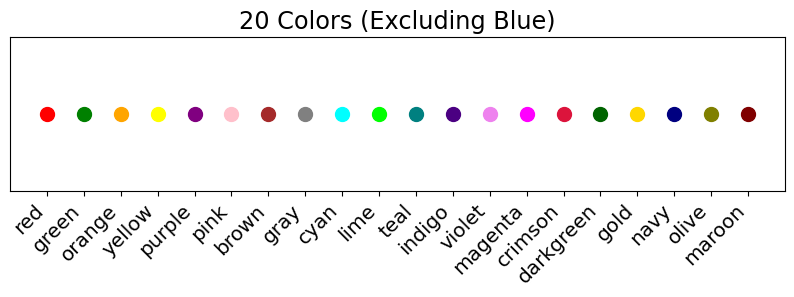

In [18]:
# Define a color palette excluding blue
colors = [
    'red', 'green', 'orange', 'yellow', 'purple', 'pink', 'brown', 'gray', 'cyan', 'lime',
    'teal', 'indigo', 'violet', 'magenta', 'crimson', 'darkgreen', 'gold',
    'navy', 'olive', 'maroon'
]

# Display the colors
plt.figure(figsize=(10, 2))
for i, color in enumerate(colors):
    plt.scatter(i, 1, color=color, s=100, label=color)
plt.xlim(-1, len(colors))
plt.ylim(0, 2)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xticks(range(len(colors)), colors, rotation=45, ha="right")
plt.title("20 Colors (Excluding Blue)")
plt.show()

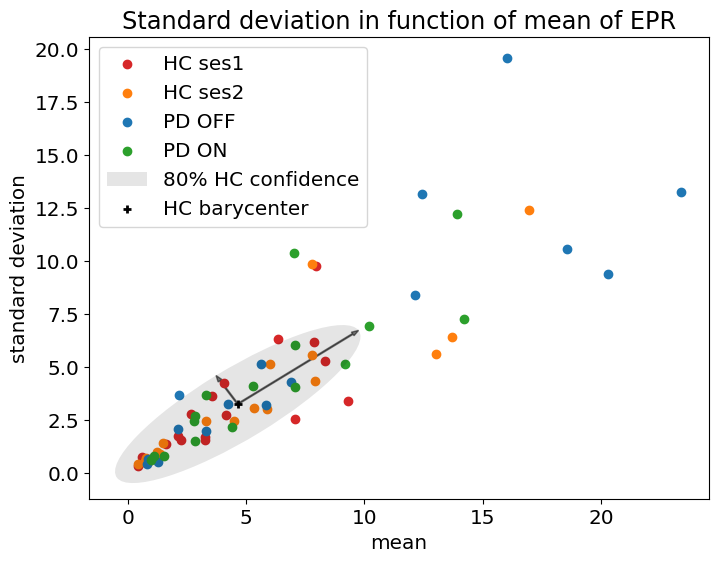

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

x = data_mean[0].tolist()+data_mean[1].tolist()
y = data_std[0].tolist()+data_std[1].tolist()
N = len(x)  # Number of data points

barycentre_mean_std = [np.mean(data_mean[0].tolist()+data_mean[1].tolist()),np.mean(data_std[0].tolist()+data_std[1].tolist())]
barycenter = np.array(barycentre_mean_std)

# Combine into a matrix
data_ = np.vstack((x, y)).T

# Perform PCA
pca = PCA()
pca.fit(data_)
transformed = pca.transform(data_)

# Calculate standard deviations in PCA directions
std_devs = np.sqrt(pca.explained_variance_)

# Scale factors for 80% confidence (approximately 1.28σ for normal distribution)
scale_factor = 1.28  # For 80% confidence in each dimension
width = 2 * scale_factor * std_devs[0]  # Diameter for PC1
height = 2 * scale_factor * std_devs[1]  # Diameter for PC2

# Calculate the angle of the ellipse (rotation of first PC)
angle = np.degrees(np.arctan2(pca.components_[0,1], pca.components_[0,0]))


# Plot principal components as arrows ending at ellipse border
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    # Arrow length is exactly the ellipse radius (half width/height)
    length = scale_factor * np.sqrt(var)-0.3
    ax.arrow(pca.mean_[0], pca.mean_[1],
             comp[0] * length, comp[1] * length,
             color='black', alpha=0.5, width=0.05, head_width=0.2,
            )

for i,group in enumerate(group_list):
    for k in range(len(data_mean[i])):
        plt.scatter(data_mean[i].tolist()[k],data_std[i].tolist()[k],color=matplot_colors[group_to_num[group]], 
                    label=group if k==0 else '')

# Plot the ellipse
ellipse = Ellipse(xy=pca.mean_, width=width, height=height, angle=angle,
                  edgecolor='None', fc='black', alpha=.1, lw=2, linestyle='--', 
                  label=f'80% HC confidence')
ax.add_patch(ellipse)

plt.scatter(barycenter[0],barycenter[1], marker='+', linewidth = 2, color='black', label='HC barycenter')
        
plt.legend(loc='upper left')#loc='upper left'
plt.xlabel('mean')
plt.ylabel('standard deviation')
plt.title('Standard deviation in function of mean of EPR')

fig.savefig(os.path.join(save_manuscript_folder, 'mean_vs_std_EPR_log_scale_corrected.pdf'), bbox_inches='tight')
plt.show()

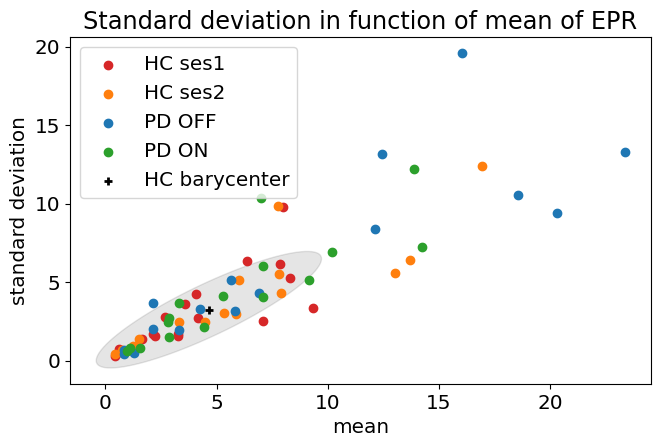

In [ ]:
# Set the figure size
fig, ax = plt.subplots(figsize=figsize)

barycentre_mean_std = [np.mean(data_mean[0].tolist()+data_mean[1].tolist()),np.mean(data_std[0].tolist()+data_std[1].tolist())]
barycenter = np.array(barycentre_mean_std)

# Parameters for the ellipse
a = 6.1  # Semi-major axis
b = 1.5  # Semi-minor axis
angle = np.radians(35)  # Rotation angle in radians
x_c, y_c = barycenter  # Center of the ellipse

# Angle values for the ellipse
theta = np.linspace(0, 2 * np.pi, 100)

# Parametric equations for the ellipse
x = a * np.cos(theta)
y = b * np.sin(theta)

# Rotation matrix
rotation_matrix = np.array([
    [np.cos(angle), -np.sin(angle)],
    [np.sin(angle), np.cos(angle)]
])

# Apply rotation
coords = np.vstack([x, y])
rotated_coords = rotation_matrix @ coords
x_rotated, y_rotated = rotated_coords[0], rotated_coords[1]

# Translate to the center (x_c, y_c)
x_translated = x_rotated + x_c
y_translated = y_rotated + y_c

# Plot the rotated and translated ellipse, filled
ax.fill(x_translated, y_translated, color='black', alpha=0.1)

for i,group in enumerate(group_list):
    for k in range(len(data_mean[i])):
        plt.scatter(data_mean[i].tolist()[k],data_std[i].tolist()[k],color=matplot_colors[group_to_num[group]], 
                    label=group if k==0 else '')

plt.scatter(barycenter[0],barycenter[1], marker='+', linewidth = 2, color='black', label='HC barycenter')
        
plt.legend(loc='upper left')#loc='upper left'
plt.xlabel('mean')
plt.ylabel('standard deviation')
plt.title('Standard deviation in function of mean of EPR')
#ax.set_xscale('log')
#ax.set_yscale('log')
fig.savefig(os.path.join(save_manuscript_folder, 'mean_vs_std_EPR_log_scale_corrected.pdf'), bbox_inches='tight')
plt.show()

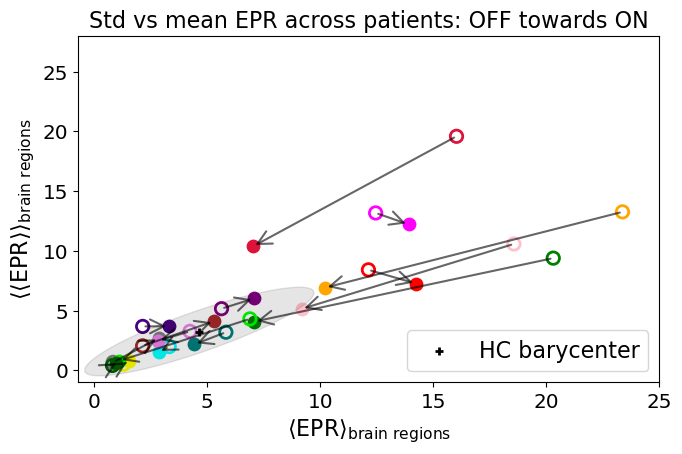

In [ ]:
# Set the figure size
fig, ax = plt.subplots(figsize=figsize)
dot_size = 80

for k in range(len(data_mean[2])):
    # Plot data2 points
    plt.scatter(data_mean[2].tolist()[k], data_std[2].tolist()[k], marker='o', edgecolors=colors[k],linewidths=2, s=dot_size, facecolors='none')

    # Plot data3 points
    plt.scatter(data_mean[3].tolist()[k], data_std[3].tolist()[k], color=colors[k], s=dot_size)
    
    # Add an arrow from data2[k] to data3[k]
    plt.annotate('',
                 xy=(data_mean[3].tolist()[k], data_std[3].tolist()[k]),  # End point (data3)
                 xytext=(data_mean[2].tolist()[k], data_std[2].tolist()[k]),  # Start point (data2)
                 arrowprops=dict(facecolor=colors[k], edgecolor='black', arrowstyle='->',
                                 lw=1.5, mutation_scale=25, alpha=0.6))


# Plot the ellipse
ellipse = Ellipse(xy=pca.mean_, width=width, height=height, angle=angle,
                  edgecolor='None', fc='black', alpha=.1, lw=2, linestyle='--', 
                  label=f'80% confidence (HC)')
ax.fill(x_translated, y_translated, color='black', alpha=0.1)

plt.scatter(barycenter[0],barycenter[1], marker='+', linewidth = 2, color='black', label='HC barycenter')

# Labels and title for the main plot with increased font size
plt.xlabel(r'$\langle$EPR$\rangle_{\text{brain regions}}$', fontsize=16)
plt.ylabel(r'$\langle\langle$EPR$\rangle\rangle_{\text{brain regions}}$', fontsize=16)
plt.title('Std vs mean EPR across patients: OFF towards ON', fontsize=16)
plt.legend(loc='lower right', fontsize=16)
plt.xlim((-0.7,25))
plt.ylim((-1,28))

# Save the figure as a PDF file
fig.savefig(os.path.join(save_manuscript_folder, 'std_mean_PD_OFF_to_ON_corrected.pdf'), bbox_inches='tight')
plt.show()


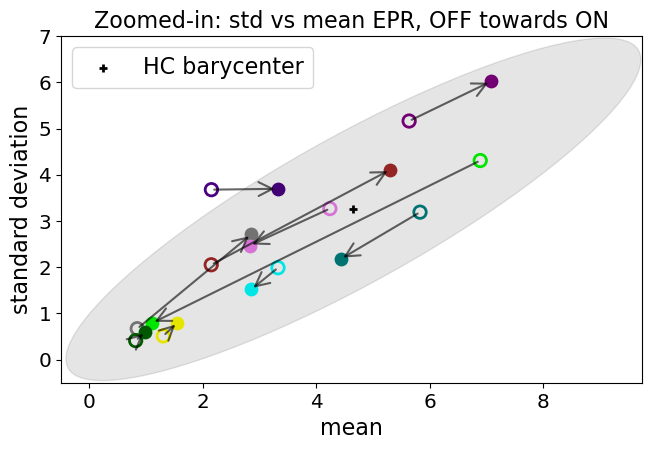

In [ ]:
# Set the figure size
fig, ax = plt.subplots(figsize=figsize)
x_limit = 10

for k in range(len(data_mean[2])):
    if (data_mean[3].tolist()[k]<10) & (data_mean[2].tolist()[k]<10):
        # Plot data2 points
        plt.scatter(data_mean[2].tolist()[k], data_std[2].tolist()[k], marker='o', edgecolors=colors[k],linewidths=2, s=dot_size, facecolors='none')
    
        # Plot data3 points
        plt.scatter(data_mean[3].tolist()[k], data_std[3].tolist()[k], color=colors[k], s=dot_size)
    
        # Add an arrow from data2[k] to data3[k]
        plt.annotate('',
                     xy=(data_mean[3].tolist()[k], data_std[3].tolist()[k]),  # End point (data3)
                     xytext=(data_mean[2].tolist()[k], data_std[2].tolist()[k]),  # Start point (data2)
                     arrowprops=dict(facecolor=colors[k], edgecolor='black', arrowstyle='->',
                                     lw=1.5, mutation_scale=25, alpha=0.6))

# Plot the ellipse
ellipse = Ellipse(xy=pca.mean_, width=width, height=height, angle=angle,
                  edgecolor='None', fc='black', alpha=.1, lw=2, linestyle='--', 
                  label=f'80% confidence (HC)')
ax.fill(x_translated, y_translated, color='black', alpha=0.1)

plt.scatter(barycenter[0],barycenter[1], marker='+', linewidth = 2, color='black', label='HC barycenter')

# Labels and title for the main plot with increased font size
plt.xlabel('mean', fontsize=16)
plt.ylabel('standard deviation', fontsize=16)
plt.title('Zoomed-in: std vs mean EPR, OFF towards ON', fontsize=16)
plt.legend(fontsize=16)
plt.xlim((-.5,9.75))
plt.ylim((-.5,7))

# Save the f8igure as a PDF file
fig.savefig(os.path.join(save_manuscript_folder, 'std_mean_PD_OFF_to_ON_zoom.pdf'), bbox_inches='tight')
plt.show()

[  1.29660121 -14.25049613 -14.56412828  -0.37545393   1.53099164
 -10.82327547  -1.70403602  -2.72128918   0.6678616    1.84701242
  -0.07884114  -1.13014306   1.57789881   0.26465711 -12.40548888
  -0.25135864]


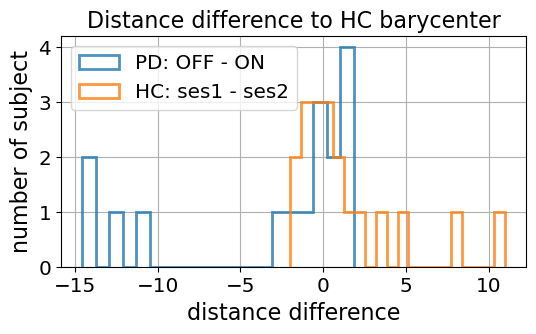

In [ ]:
# Calculate the barycenter (mean of means and stds)
barycenter = np.array([
    np.mean(data_mean[0].tolist() + data_mean[1].tolist()),
    np.mean(data_std[0].tolist() + data_std[1].tolist())
])

# Function to calculate L2 distance
def l2_distance(points, barycenter):
    return np.linalg.norm(points - barycenter, axis=1)

# Calculate distances for each dataset
def calculate_distances(mean, std):
    points = np.array([mean, std]).T
    return l2_distance(points, barycenter)

distances_data1 = calculate_distances(data_mean[0], data_std[0])
distances_data2 = calculate_distances(data_mean[1], data_std[1])
distances_data3 = calculate_distances(data_mean[2], data_std[2])
distances_data4 = calculate_distances(data_mean[3], data_std[3])

# Calculate and print the difference in distances
diff_data1_data2 = (distances_data2 - distances_data1)
diff_data3_data4 = (distances_data4 - distances_data3)
print(diff_data3_data4)

# Plot the histogram of the differences in distances
fig, ax = plt.subplots(figsize=(6, 3))
plt.hist(diff_data3_data4, bins=20, histtype='step', linewidth=2, label='PD: OFF - ON', alpha=.8)
plt.hist(diff_data1_data2, bins=20, histtype='step', linewidth=2, label='HC: ses1 - ses2', alpha=.8)

# Add labels and title
plt.title('Distance difference to HC barycenter', fontsize=16)
plt.xlabel('distance difference', fontsize=16)
plt.ylabel('number of subject', fontsize=16)
plt.grid(True)
plt.legend()

# Save and show the plot
fig.savefig(os.path.join(save_manuscript_folder, 'distance_histograms_between_sessions.pdf'), bbox_inches='tight')
plt.show()

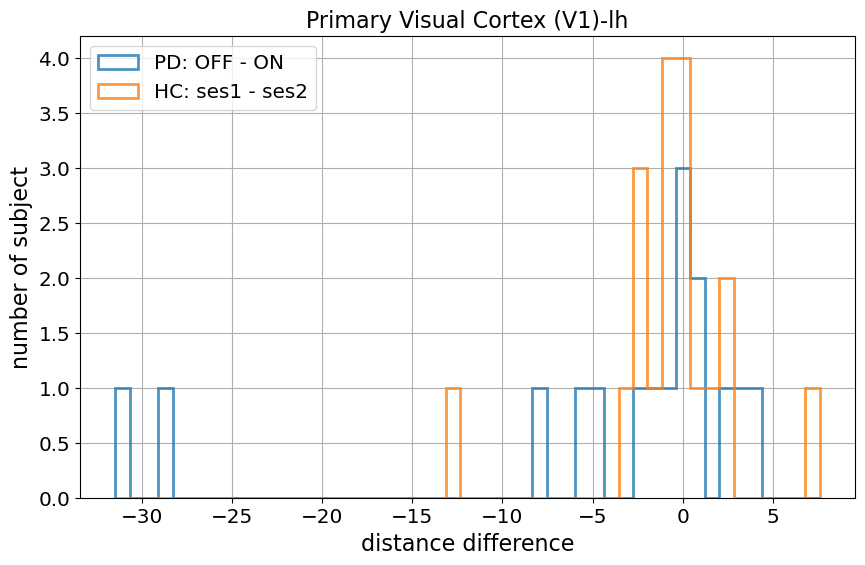

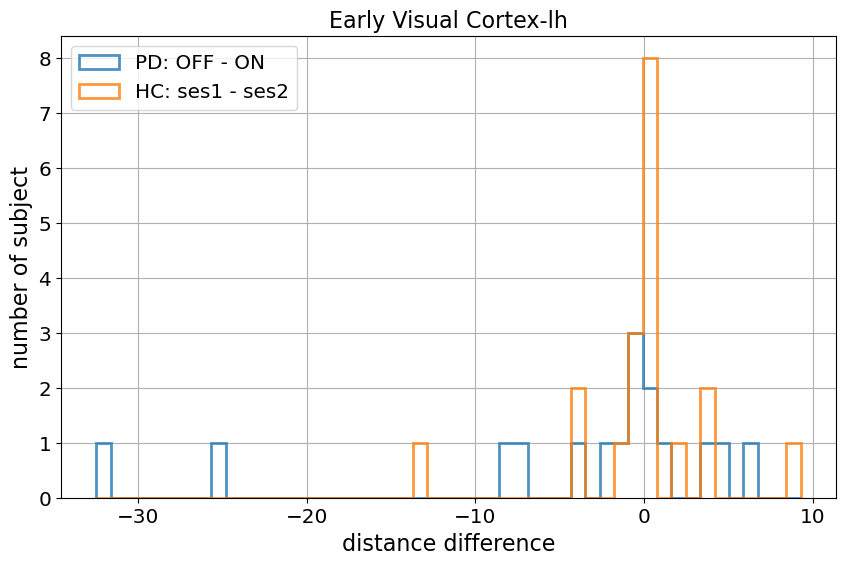

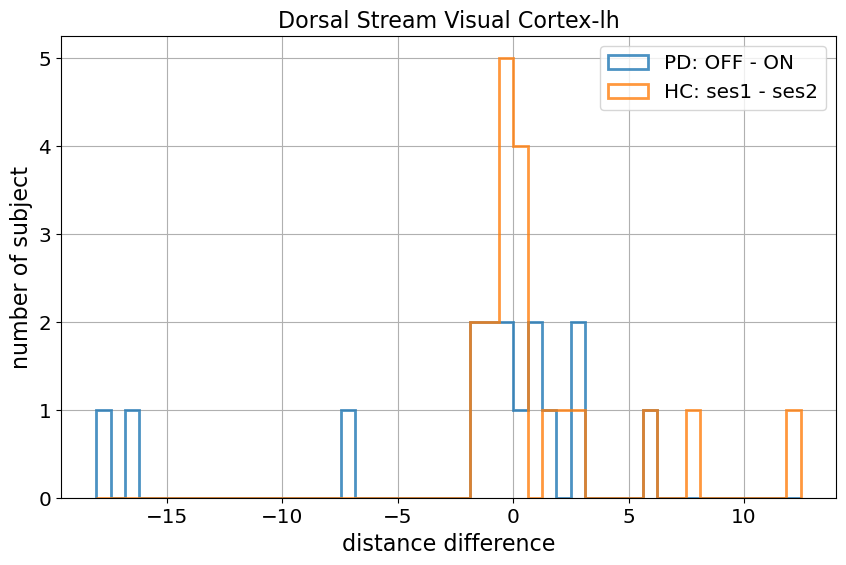

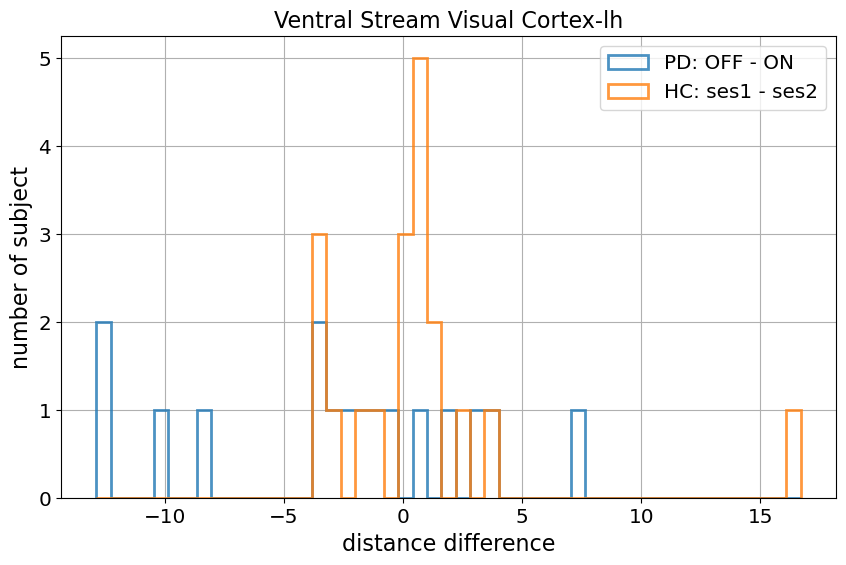

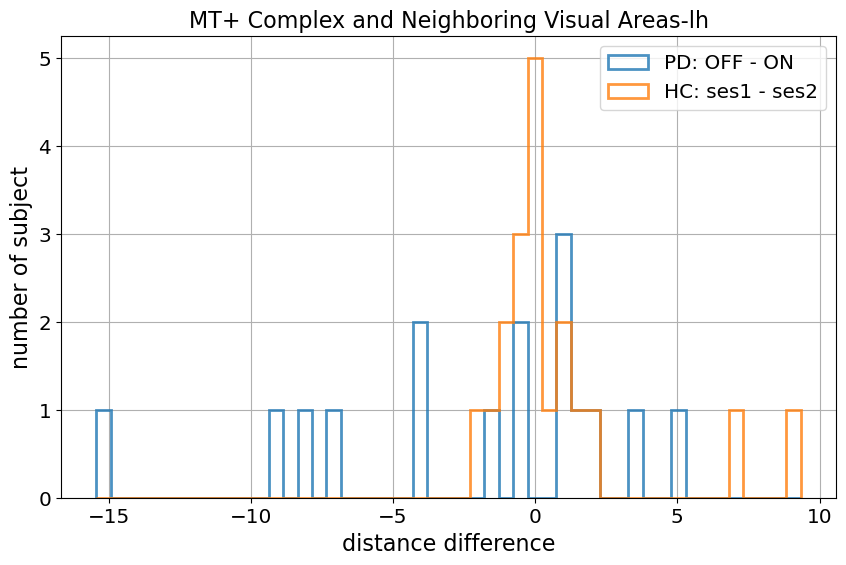

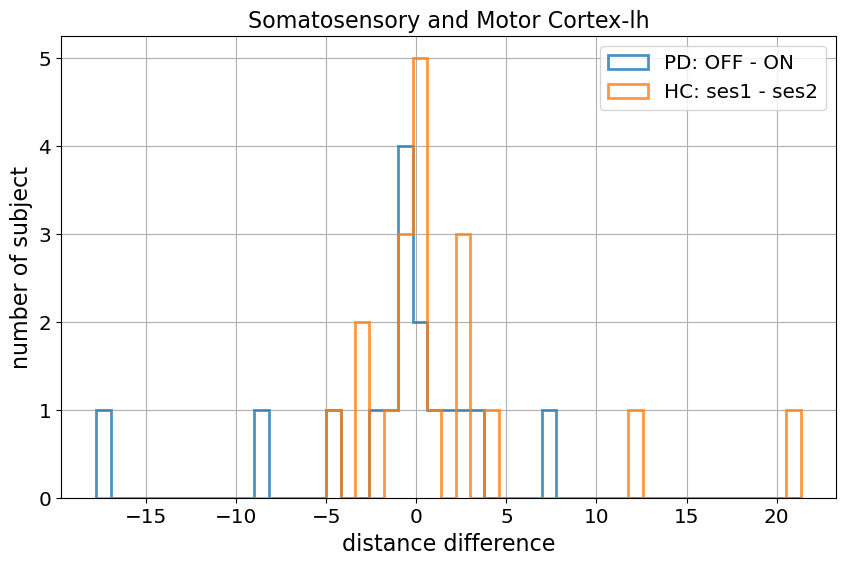

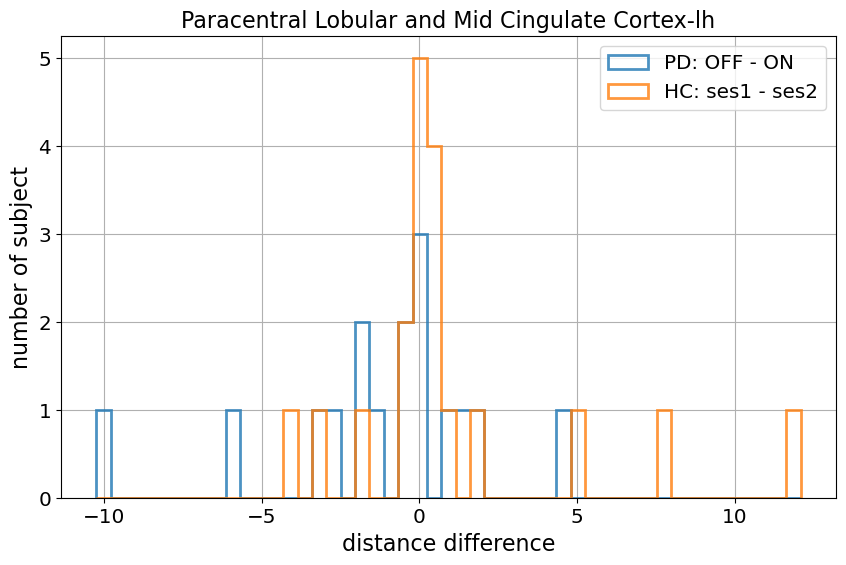

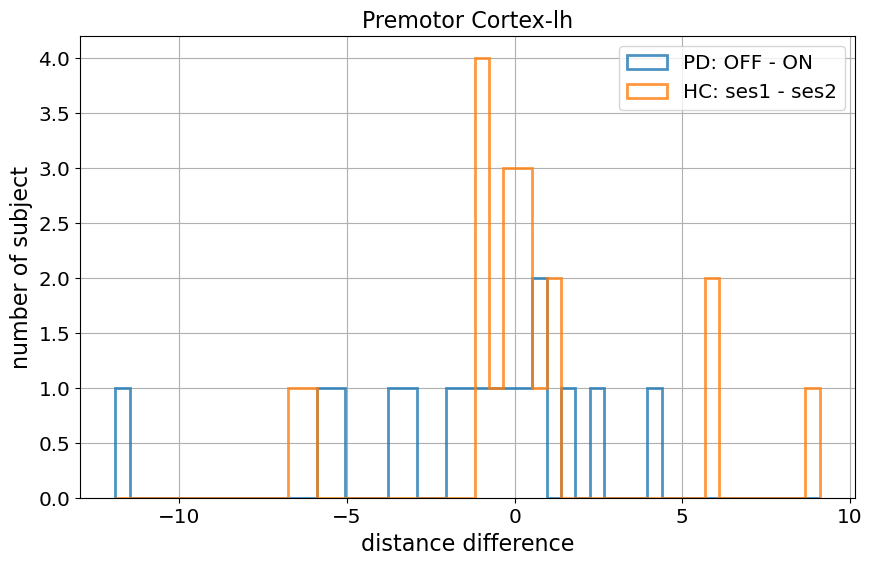

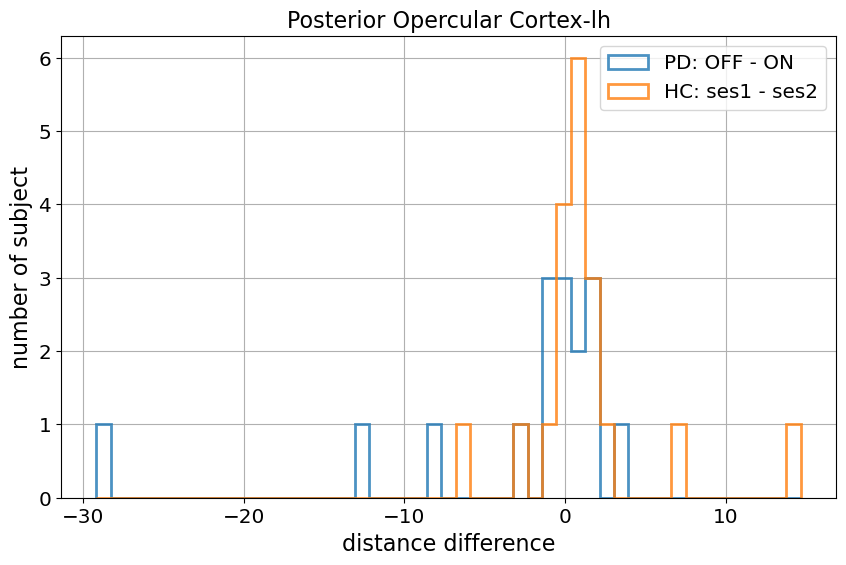

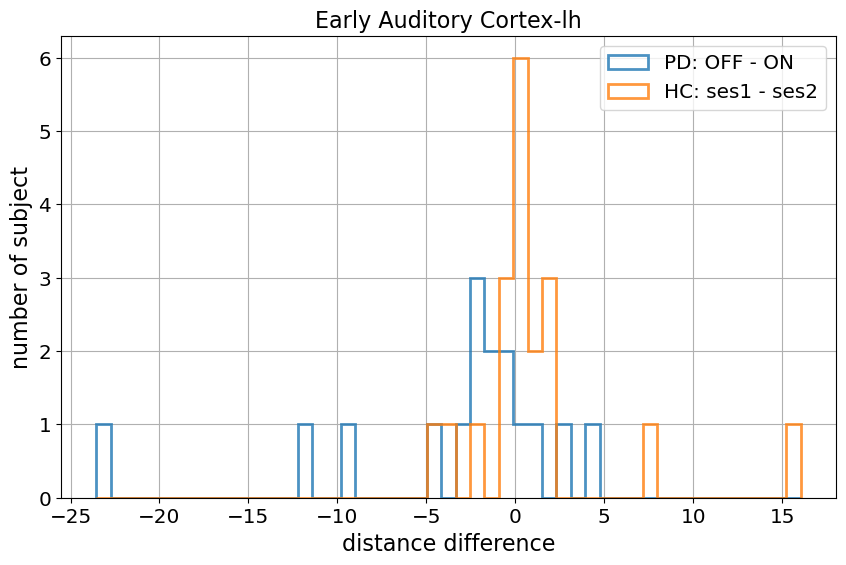

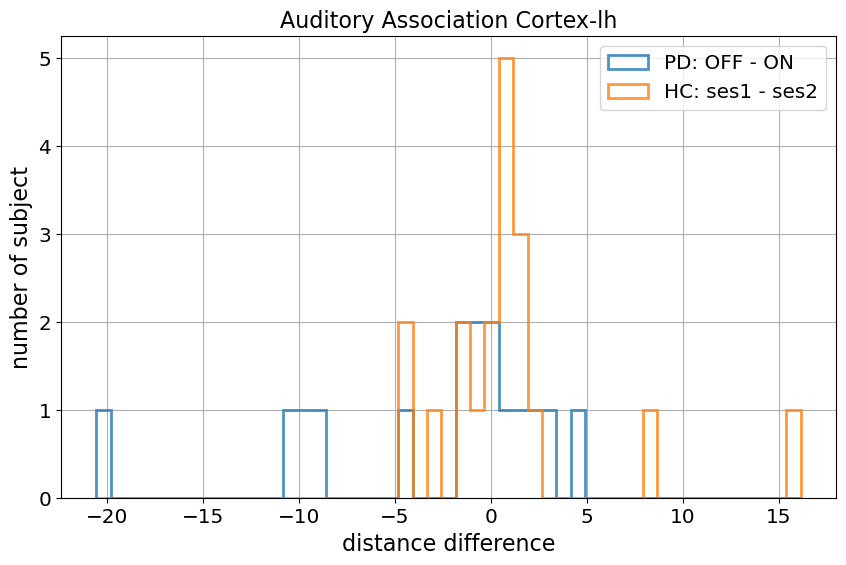

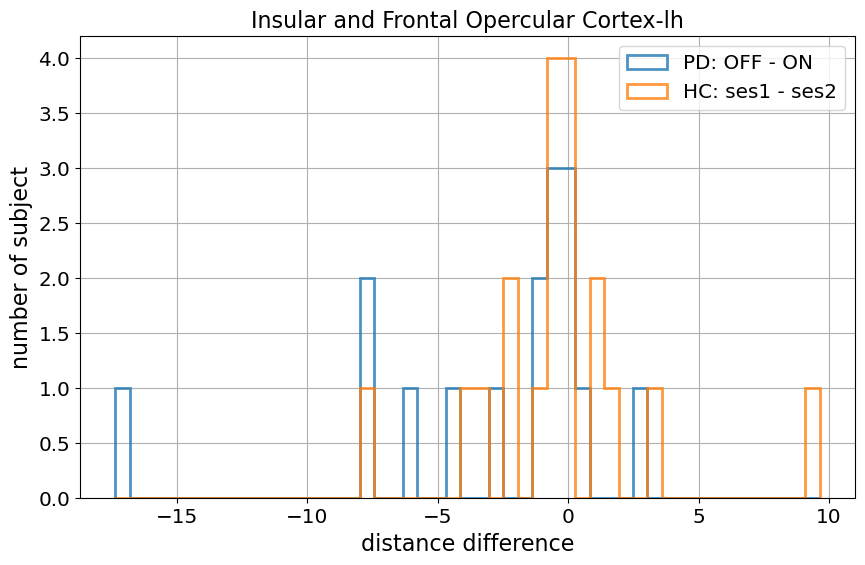

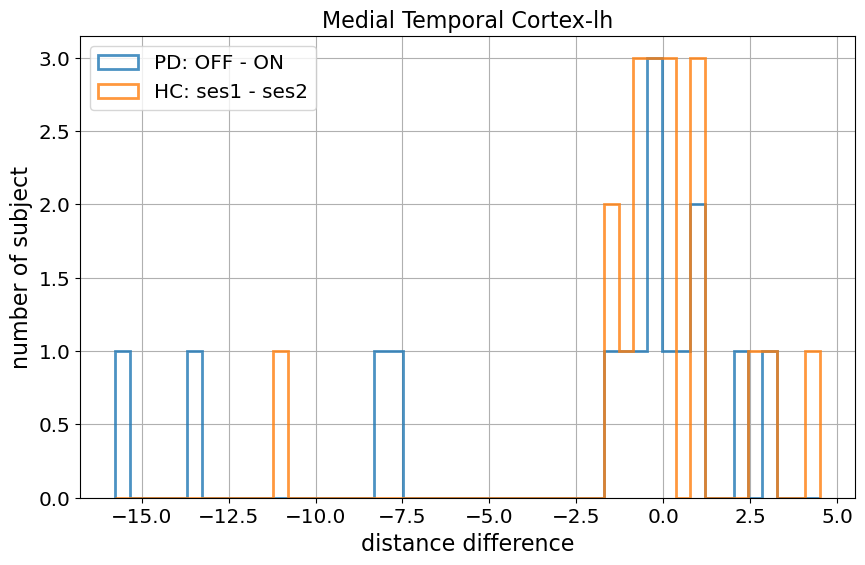

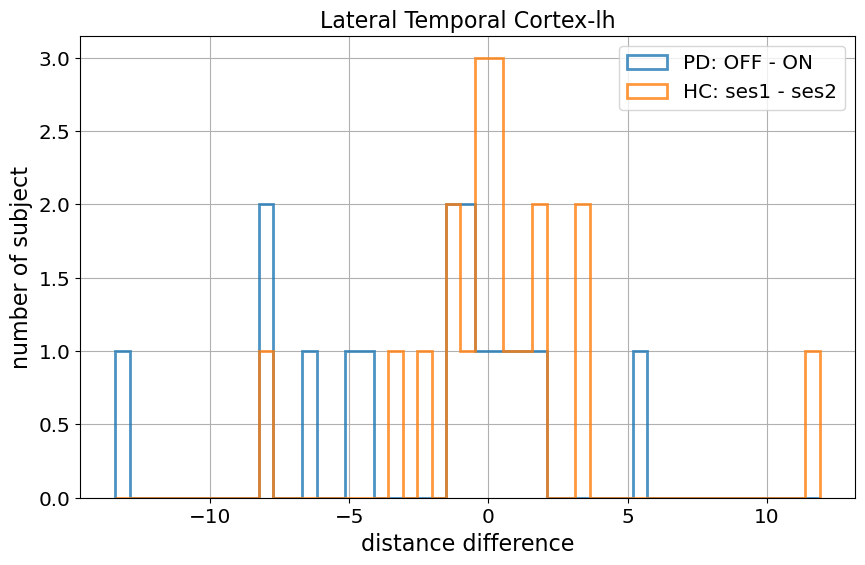

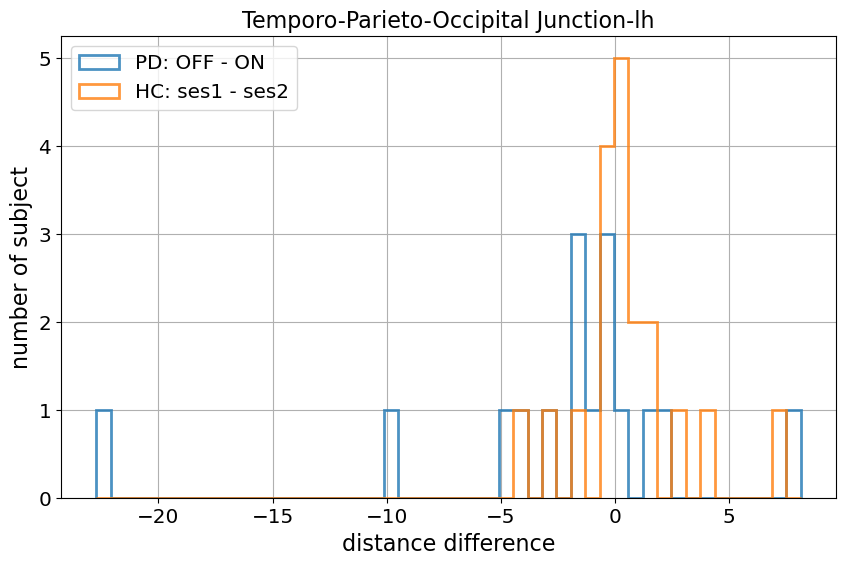

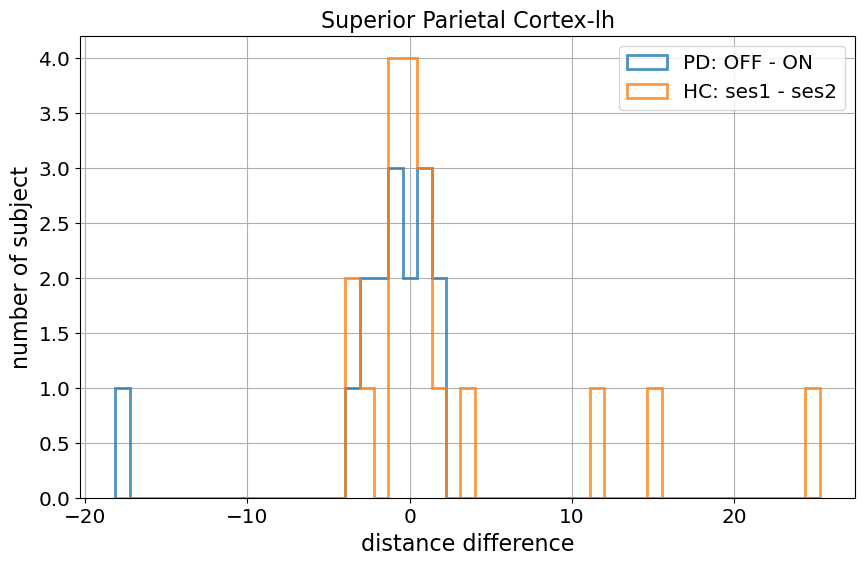

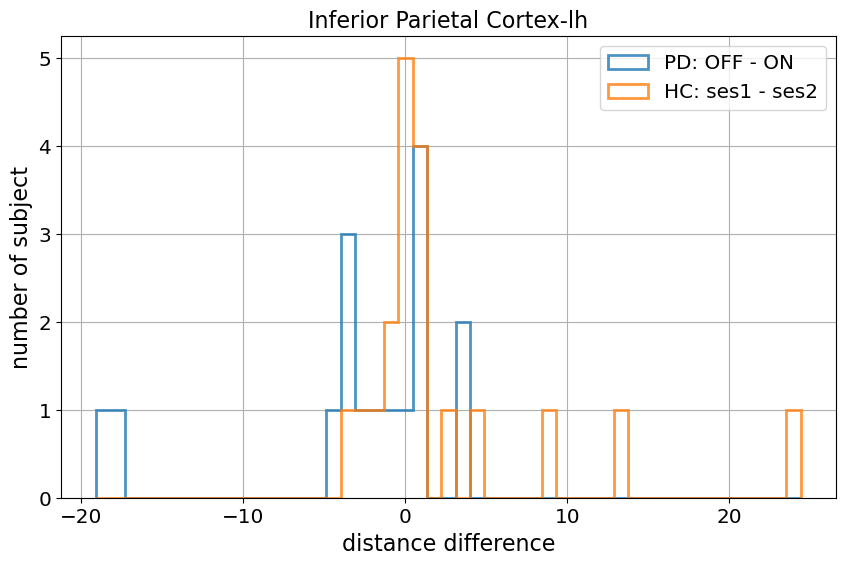

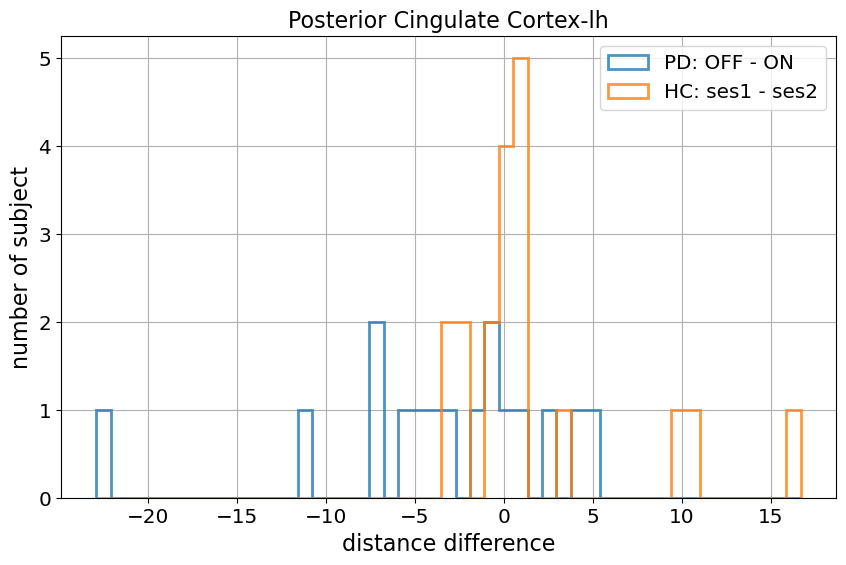

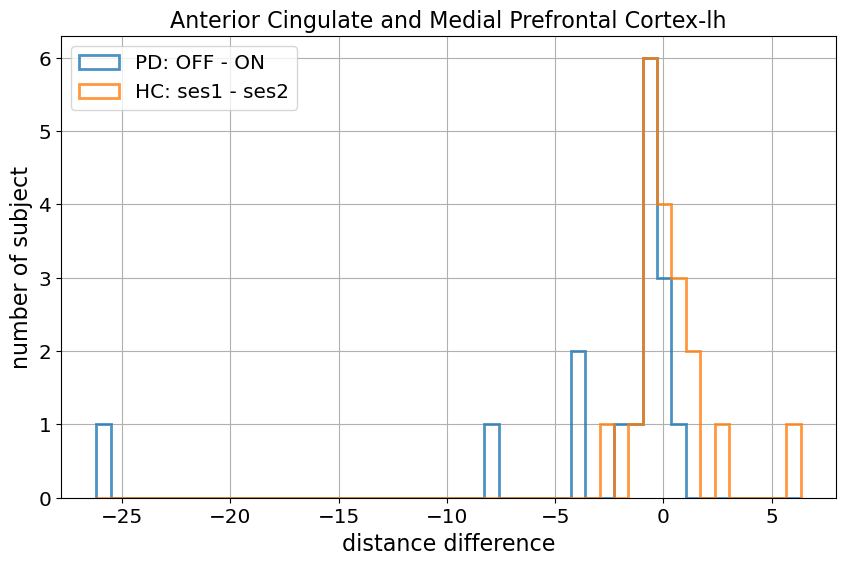

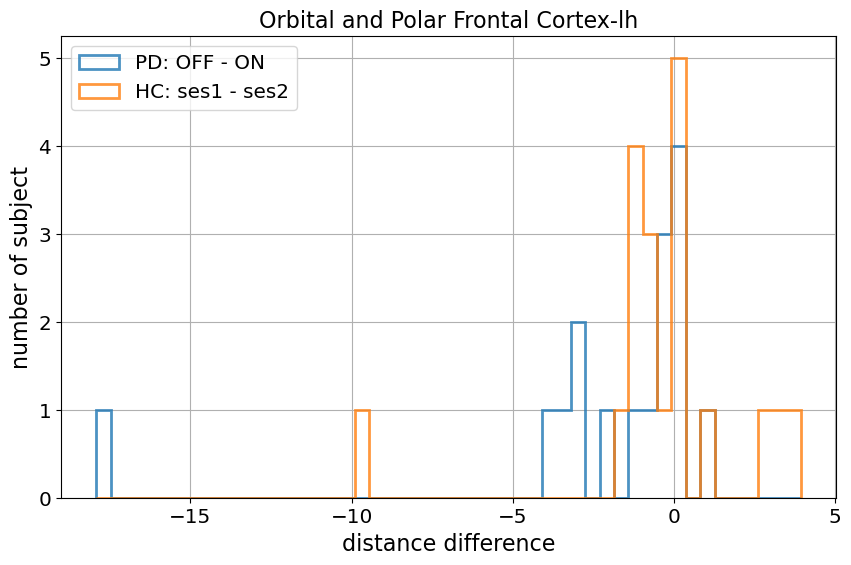

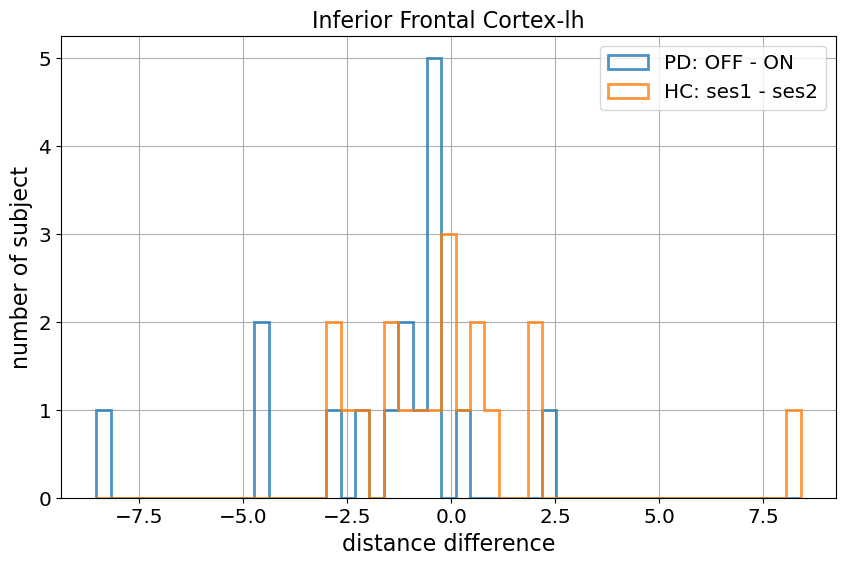

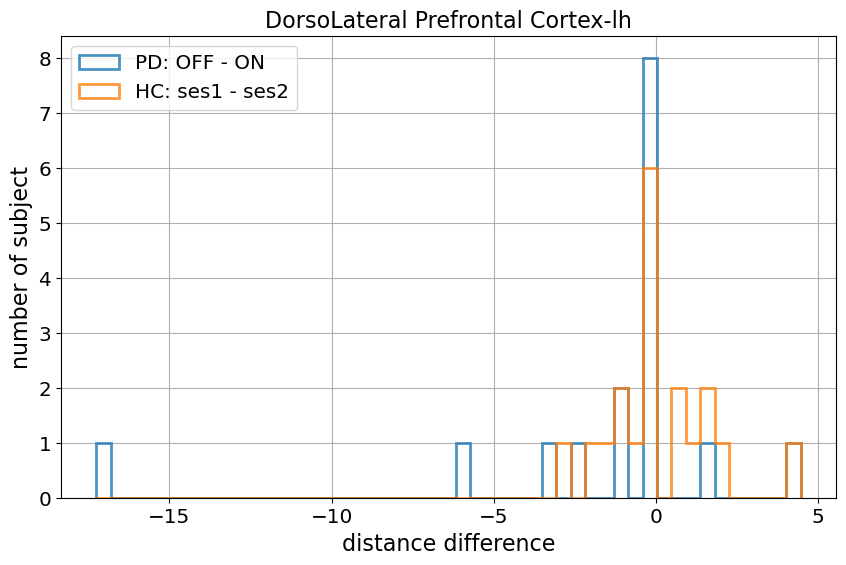

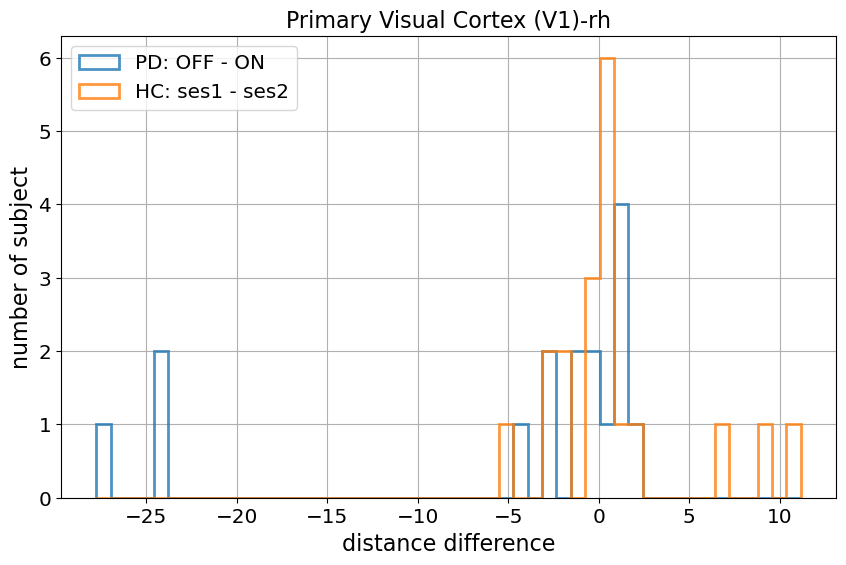

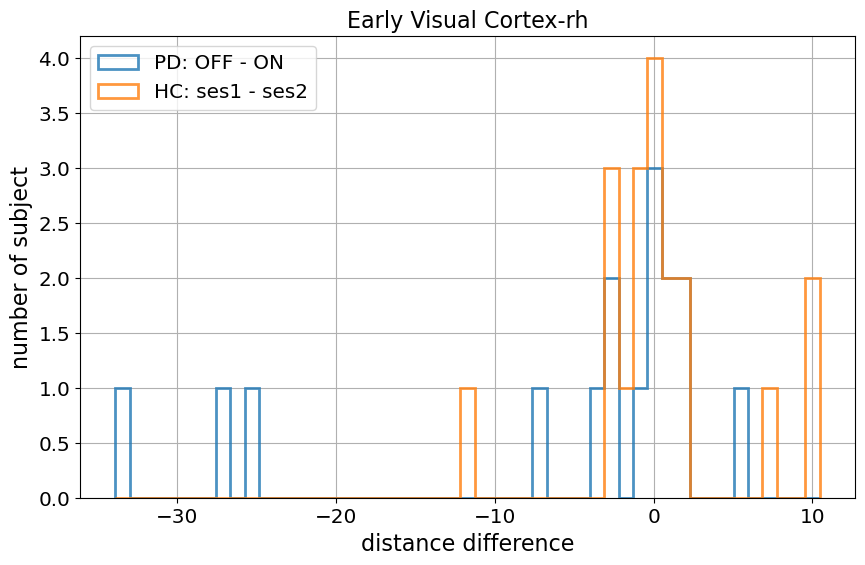

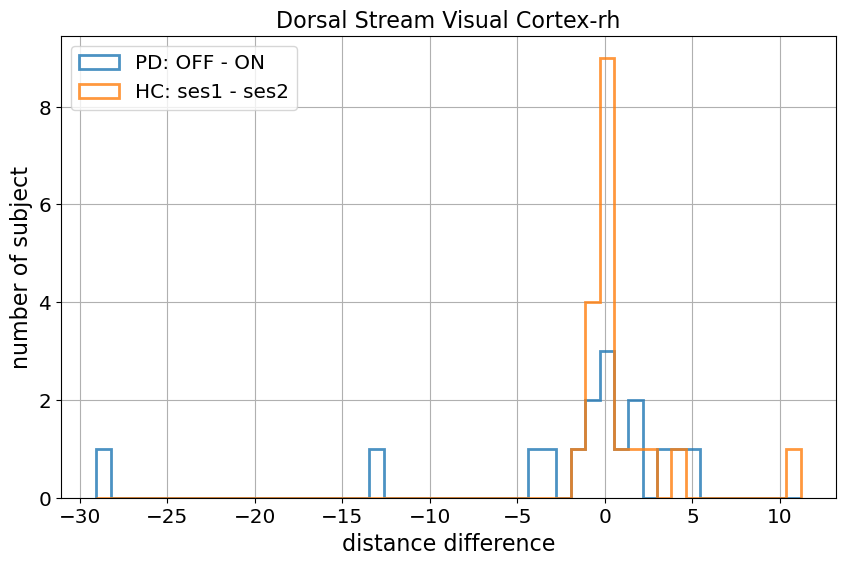

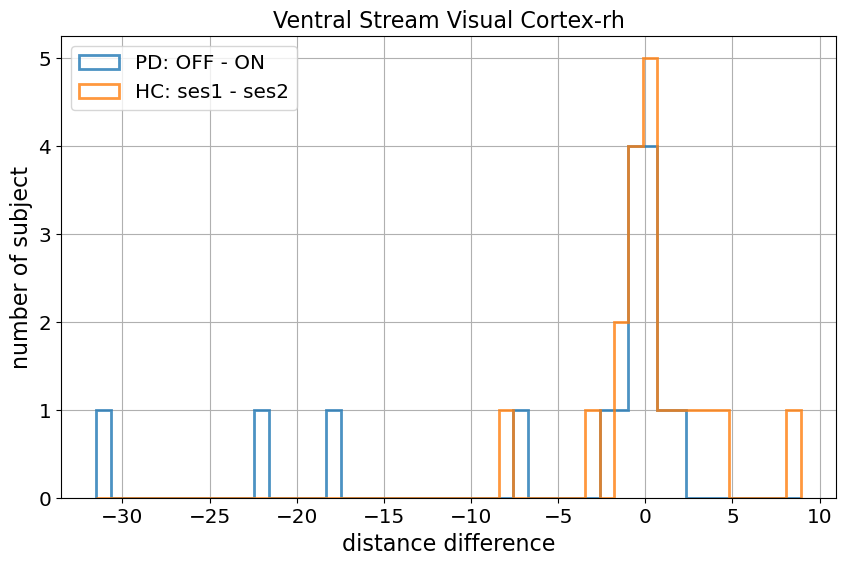

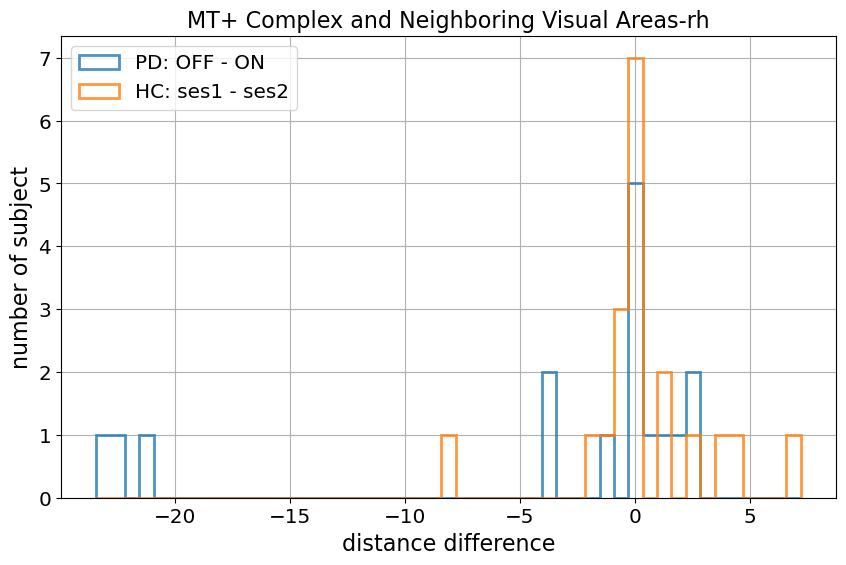

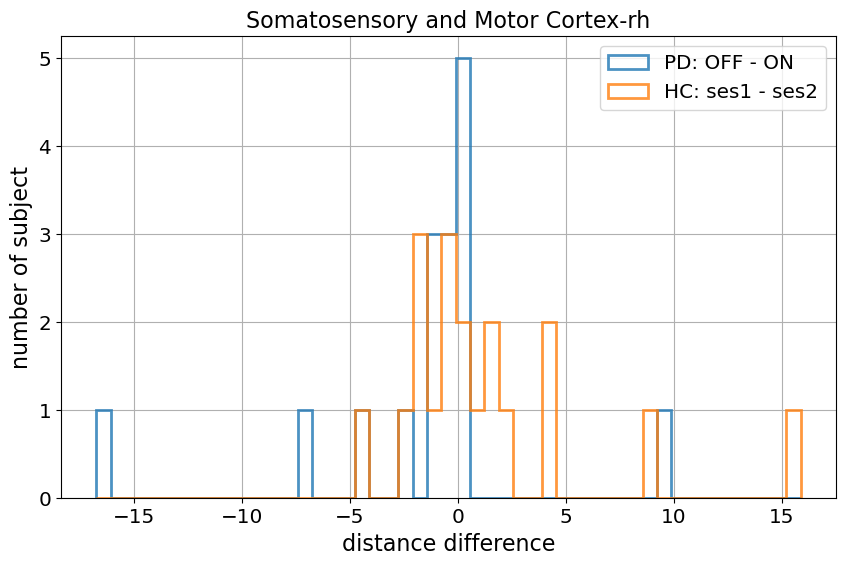

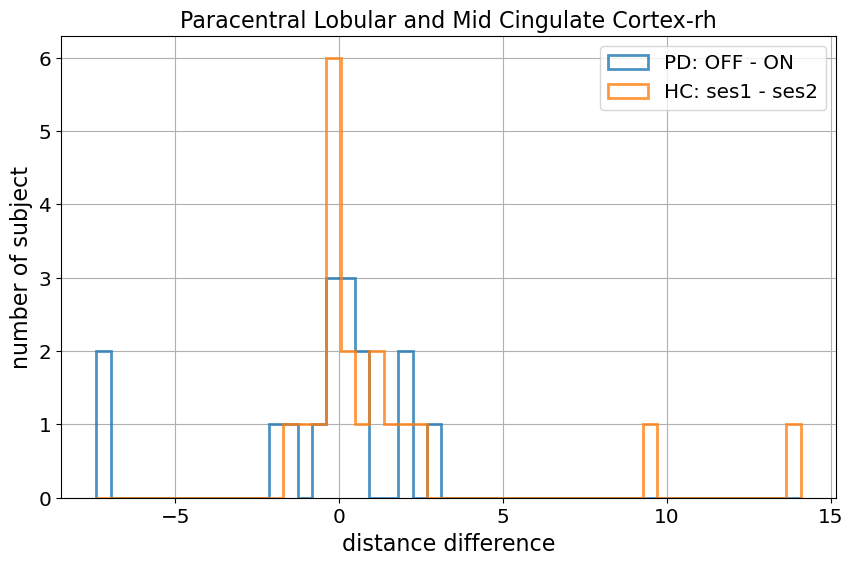

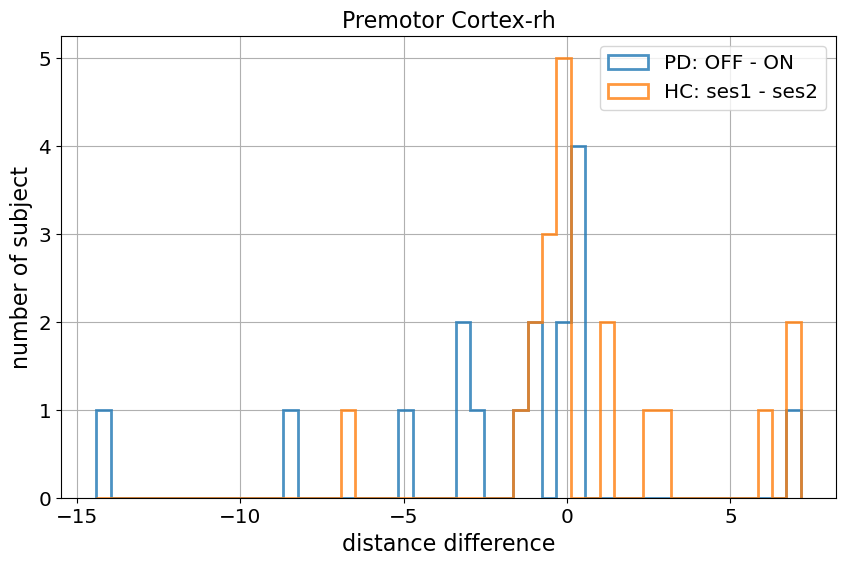

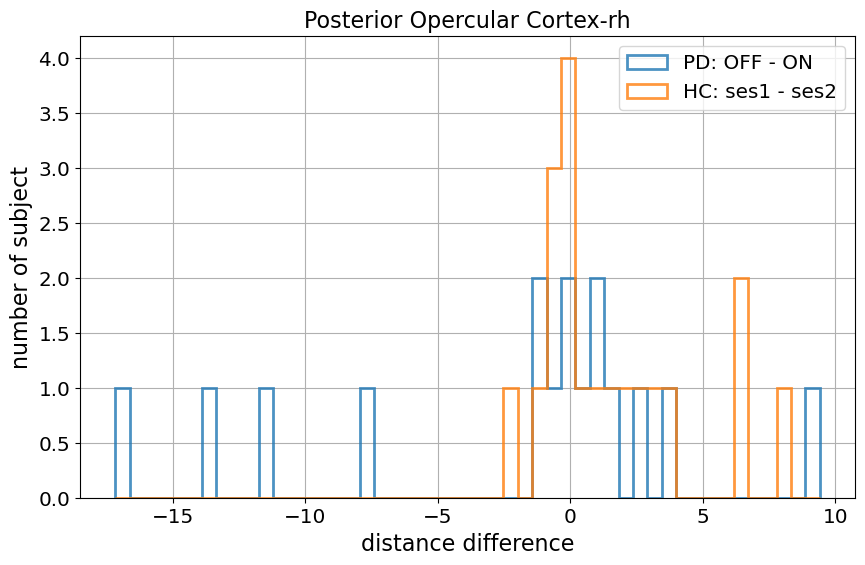

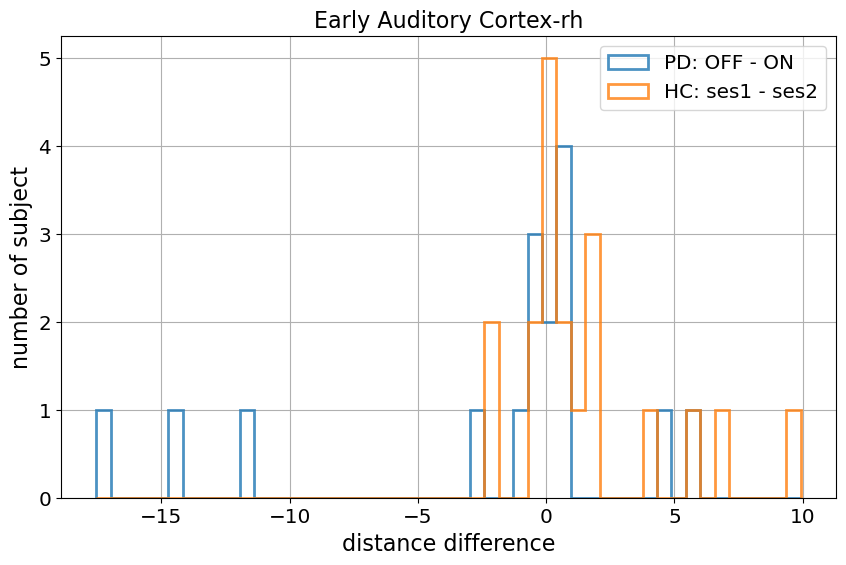

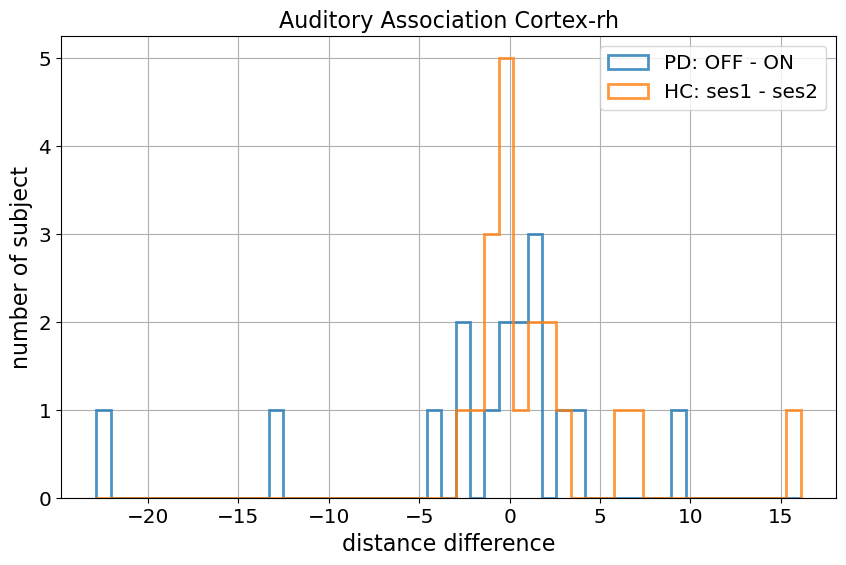

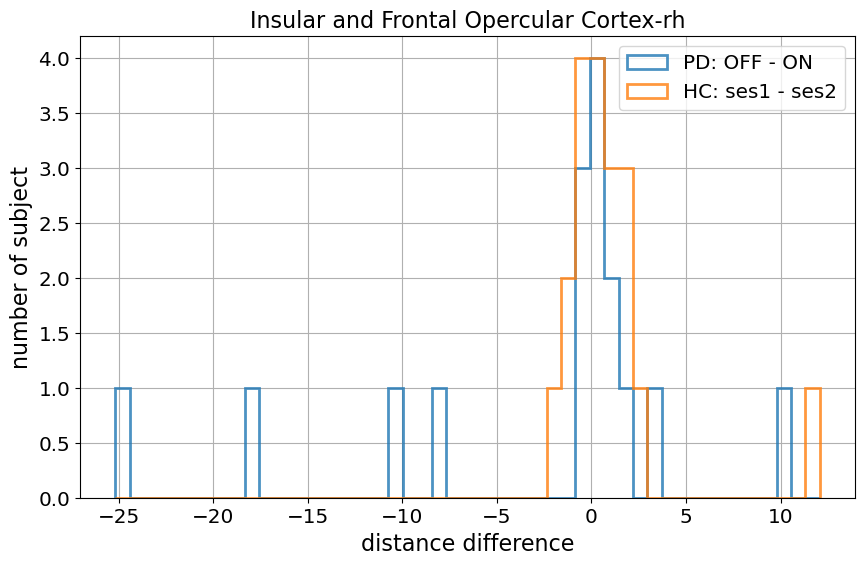

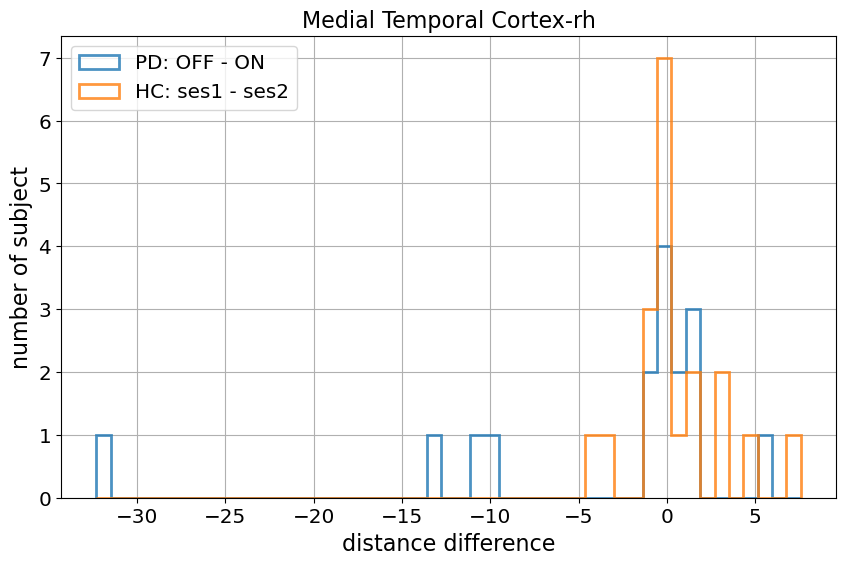

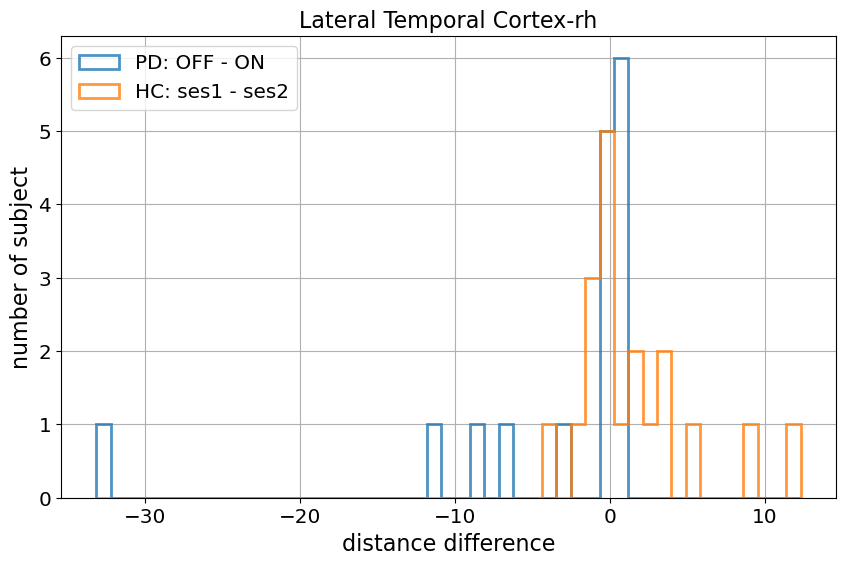

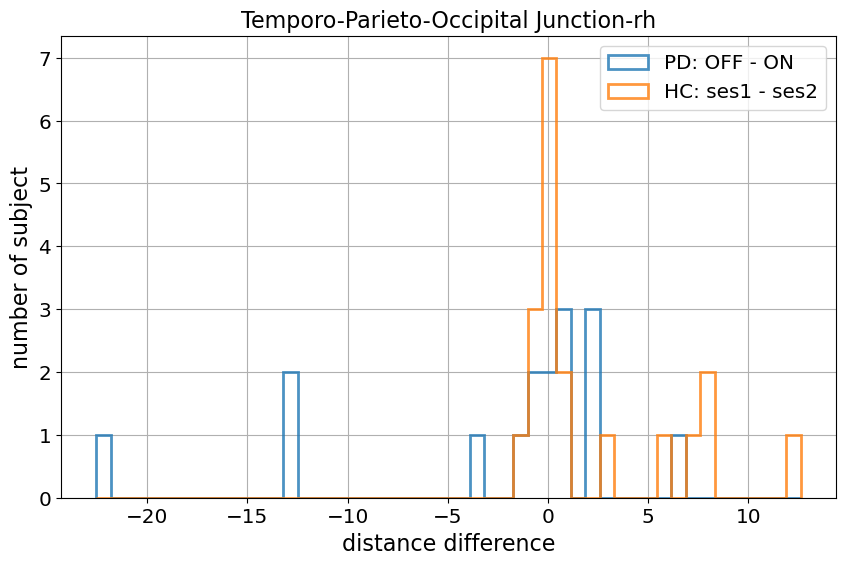

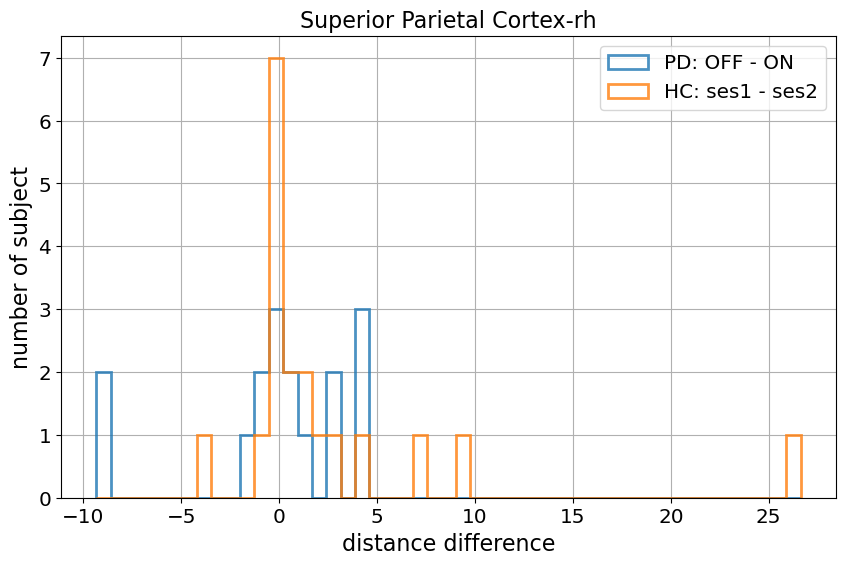

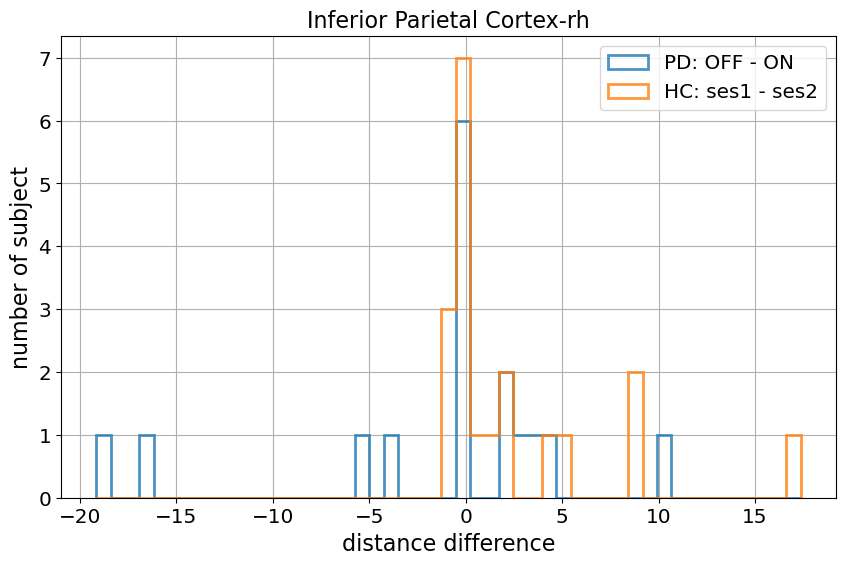

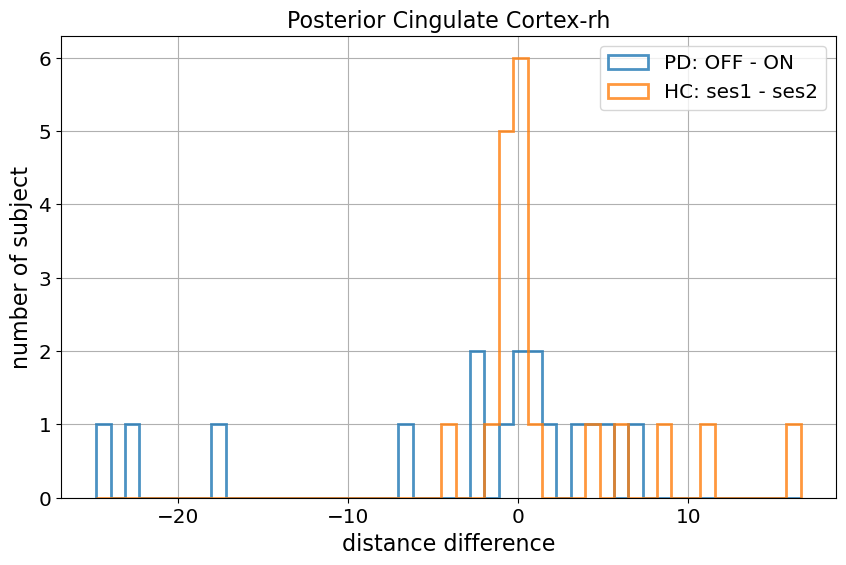

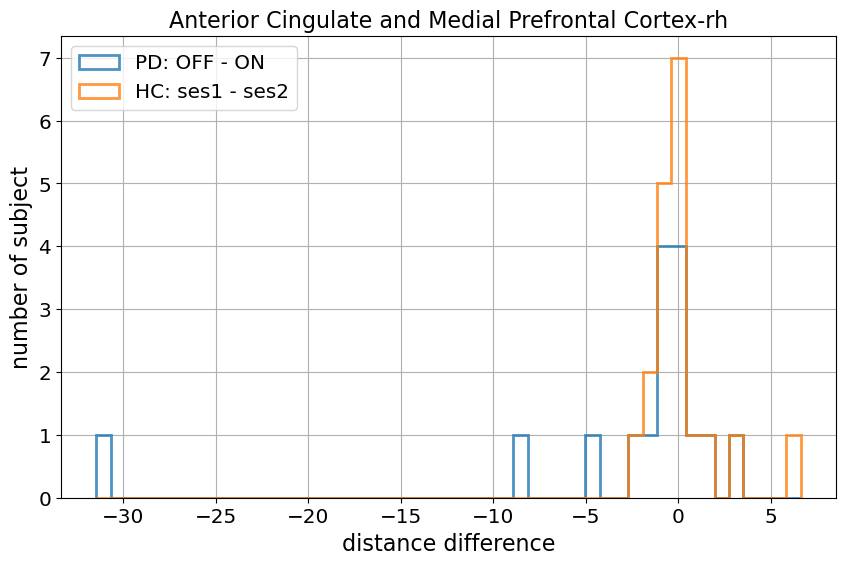

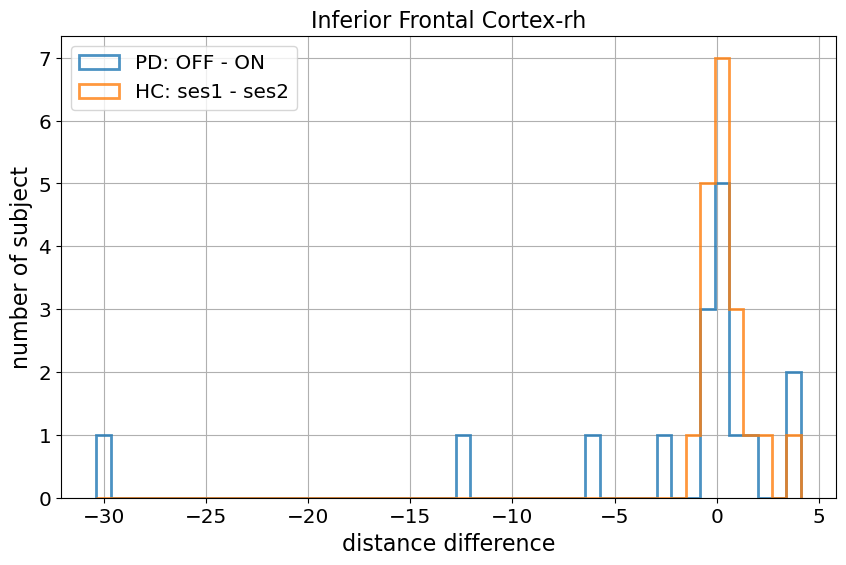

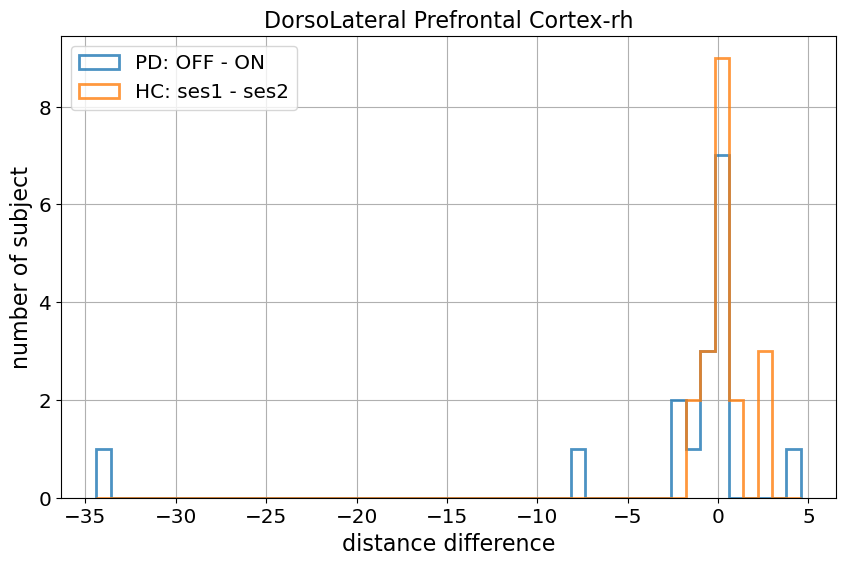

In [ ]:
for region in data['HC ses1'].columns[:-8]:
    data1_region = data['HC ses1'][region]
    data2_region = data['HC ses2'][region]
    data3_region = data['PD OFF'][region]
    data4_region = data['PD ON'][region]

    barycenter = np.mean(data1_region.tolist()+data2_region.tolist())

    # Calculate differences
    diff_pd = np.abs(data4_region - barycenter) - np.abs(data3_region - barycenter)
    diff_hc = np.abs(data2_region - barycenter) - np.abs(data1_region - barycenter)

    # Determine bin edges
    combined_data = np.concatenate([diff_pd, diff_hc])
    bin_edges = np.linspace(combined_data.min(), combined_data.max(), num=50)  # 20 bins

    # Plot the histogram of the differences in distances
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.hist(diff_pd, bins=bin_edges, histtype='step', linewidth=2, label='PD: OFF - ON', alpha=.8)#, density=True
    plt.hist(diff_hc, bins=bin_edges, histtype='step', linewidth=2, label='HC: ses1 - ses2', alpha=.8)#, density=True

    # Add labels and title
    plt.title(region_acronym_to_full[region], fontsize=16)
    plt.xlabel('distance difference', fontsize=16)
    plt.ylabel('number of subject', fontsize=16)
    #ax.set_xscale('log')
    plt.grid(True)
    plt.legend()
    fig.savefig(os.path.join(save_manuscript_folder, 'distance_histograms_between_sessions', f'distance_histograms_between_sessions_{region}.pdf'), bbox_inches='tight')
    plt.show()


/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_7899/1223234548.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted_global = x_global[sorted_indices_global]
/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_7899/1223234548.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_fit_sorted_global = y_fit_global[sorted_indices_global]
/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_7899/1223234548.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

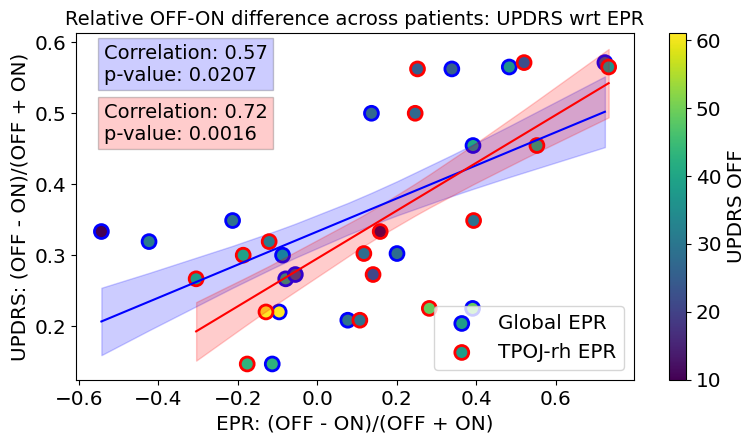

In [ ]:
# Assuming data_mean and data are already defined
sigma_off = data_mean[2]
sigma_on = data_mean[3]
updrs_off = data['PD OFF']['UPDRS']
updrs_on = data['PD ON']['UPDRS']
x_global = (sigma_off - sigma_on) / (sigma_off + sigma_on)
y_global = (updrs_off - updrs_on) / (updrs_off + updrs_on)

# Perform linear regression for global data
slope_global, intercept_global, r_value_global, p_value_global, std_err_global = linregress(x_global, y_global)

# Calculate the fitted values for global data
y_fit_global = intercept_global + slope_global * x_global

# Calculate the confidence interval for the fit for global data
y_err_global = std_err_global * np.sqrt(1/len(x_global) + (x_global - np.mean(x_global))**2 / np.sum((x_global - np.mean(x_global))**2))

# Plot the data
fig, ax = plt.subplots(figsize=(9, 4.5))
scatter_global = ax.scatter(x_global, y_global, s=100, c=updrs_off, cmap='viridis', label='Global EPR', edgecolor='blue', linewidth=2)

# Sort x values for fill_between
sorted_indices_global = np.argsort(x_global)
x_sorted_global = x_global[sorted_indices_global]
y_fit_sorted_global = y_fit_global[sorted_indices_global]
y_err_sorted_global = y_err_global[sorted_indices_global]

# Plot the regression line and shade the confidence interval for global data
ax.plot(x_sorted_global, y_fit_sorted_global, color='blue')
ax.fill_between(x_sorted_global, y_fit_sorted_global - y_err_sorted_global, y_fit_sorted_global + y_err_sorted_global, color='blue', alpha=0.2)

# Add a colorbar
cbar = plt.colorbar(scatter_global, ax=ax)
cbar.set_label('UPDRS OFF')

# Add correlation coefficient and p-value to the plot for global data
ax.text(0.05, 0.97, f'Correlation: {r_value_global:.2f}\np-value: {p_value_global:.4f}',
        transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='blue', alpha=0.2))

# Repeat for the specific region
region_name = region_full_to_acronym['Temporo-Parieto-Occipital Junction-rh']
sigma_off_region = data['PD OFF'][region_name]
sigma_on_region = data['PD ON'][region_name]
x_region = (sigma_off_region - sigma_on_region) / (sigma_off_region + sigma_on_region)
y_region = (updrs_off - updrs_on) / (updrs_off + updrs_on)

# Perform linear regression for the region data
slope_region, intercept_region, r_value_region, p_value_region, std_err_region = linregress(x_region, y_region)

# Calculate the fitted values for the region data
y_fit_region = intercept_region + slope_region * x_region

# Calculate the confidence interval for the fit for the region data
y_err_region = std_err_region * np.sqrt(1/len(x_region) + (x_region - np.mean(x_region))**2 / np.sum((x_region - np.mean(x_region))**2))

# Plot the data for the region
scatter_region = ax.scatter(x_region, y_region, s=100, c=updrs_off, cmap='viridis', label='TPOJ-rh EPR', edgecolor='red', linewidth=2)

# Sort x values for fill_between for the region
sorted_indices_region = np.argsort(x_region)
x_sorted_region = x_region[sorted_indices_region]
y_fit_sorted_region = y_fit_region[sorted_indices_region]
y_err_sorted_region = y_err_region[sorted_indices_region]

# Plot the regression line and shade the confidence interval for the region data
ax.plot(x_sorted_region, y_fit_sorted_region, color='red')
ax.fill_between(x_sorted_region, y_fit_sorted_region - y_err_sorted_region, y_fit_sorted_region + y_err_sorted_region, color='red', alpha=0.2)

# Add correlation coefficient and p-value to the plot for the region data
ax.text(0.05, 0.80, f'Correlation: {r_value_region:.2f}\np-value: {p_value_region:.4f}',
        transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='red', alpha=0.2))

ax.set_xlabel('EPR: (OFF - ON)/(OFF + ON)')
ax.set_ylabel('UPDRS: (OFF - ON)/(OFF + ON)')
ax.set_title(r'Relative OFF-ON difference across patients: UPDRS wrt EPR', fontsize=14)

leg = ax.legend(loc='lower right')

fig.savefig(os.path.join(save_manuscript_folder, f'Global_and_{region_name}_EPR_vs_UPDRS_PD_OFF_to_ON.pdf'), bbox_inches='tight')
plt.show()


In [ ]:
list_corr = []
data_relative_on_off = {}
for region in data['HC ses1'].columns[:-8]:
    sigma_off = data['PD OFF'][region]
    sigma_on = data['PD ON'][region]
    data_relative_on_off[region]=(sigma_off-sigma_on)/(sigma_off + sigma_on)
    list_corr.append(pearsonr(data_relative_on_off[region], y))
    
data_relative_on_off['UPDRS'] = y_global
data_relative_on_off = pd.DataFrame(data_relative_on_off)

df_corr_updrs_sigma = {}
df_corr_updrs_sigma['region'] = [region_acronym_to_full[region] for region in data['HC ses1'].columns[:-8]]
df_corr_updrs_sigma['correlation'] = np.array(list_corr)[:,0]
df_corr_updrs_sigma['p-value'] = np.array(list_corr)[:,1]
df_corr_updrs_sigma = pd.DataFrame(df_corr_updrs_sigma)
df_corr_updrs_sigma.sort_values(by='p-value')

region  correlation   p-value
36              Temporo-Parieto-Occipital Junction-rh     0.721492  0.001606
40  Anterior Cingulate and Medial Prefrontal Corte...     0.643279  0.007181
25                    Ventral Stream Visual Cortex-rh     0.638594  0.007756
34                          Medial Temporal Cortex-rh     0.632901  0.008503
31                           Early Auditory Cortex-rh     0.586122  0.017030
35                         Lateral Temporal Cortex-rh     0.571332  0.020786
26        MT+ Complex and Neighboring Visual Areas-rh     0.568379  0.021607
20                         Inferior Frontal Cortex-lh     0.563378  0.023055
6     Paracentral Lobular and Mid Cingulate Cortex-lh     0.562102  0.023436
18  Anterior Cingulate and Medial Prefrontal Corte...     0.560163  0.024024
38                        Inferior Parietal Cortex-rh     0.558815  0.024439
42                  DorsoLateral Prefrontal Cortex-rh     0.553331  0.026187
21                  DorsoLateral Prefrontal Cortex-lh     0.550674  0.027067
19                Orbital and Polar Frontal Cortex-lh     0.550550  0.027109
7                                  Premotor Cortex-lh     0.550109  0.027257
29                                 Premotor Cortex-rh     0.523043  0.037622
28    Paracentral Lobular and Mid Cingulate Cortex-rh     0.513438  0.041935
27                  Somatosensory and Motor Cortex-rh     0.499938  0.048613
23                             Early Visual Cortex-rh     0.466266  0.068687
39                      Posterior Cingulate Cortex-rh     0.457290  0.074930
8                       Posterior Opercular Cortex-lh     0.454641  0.076849
2                      Dorsal Stream Visual Cortex-lh     0.445663  0.083616
11            Insular and Frontal Opercular Cortex-lh     0.444305  0.084676
12                          Medial Temporal Cortex-lh     0.436681  0.090804
22                      Primary Visual Cortex (V1)-rh     0.433979  0.093051
37                        Superior Parietal Cortex-rh     0.420931  0.104456
30                      Posterior Opercular Cortex-rh     0.406927  0.117754
14              Temporo-Parieto-Occipital Junction-lh     0.406721  0.117959
32                     Auditory Association Cortex-rh     0.402931  0.121756
9                            Early Auditory Cortex-lh     0.378764  0.147976
24                     Dorsal Stream Visual Cortex-rh     0.364009  0.165738
4         MT+ Complex and Neighboring Visual Areas-lh     0.359698  0.171185
13                         Lateral Temporal Cortex-lh     0.350845  0.182739
41                         Inferior Frontal Cortex-rh     0.350470  0.183241
10                     Auditory Association Cortex-lh     0.338168  0.200160
33            Insular and Frontal Opercular Cortex-rh     0.335995  0.203252
1                              Early Visual Cortex-lh     0.335029  0.204635
3                     Ventral Stream Visual Cortex-lh     0.333106  0.207408
16                        Inferior Parietal Cortex-lh     0.328504  0.214140
17                      Posterior Cingulate Cortex-lh     0.323759  0.221228
5                   Somatosensory and Motor Cortex-lh     0.297250  0.263540
0                       Primary Visual Cortex (V1)-lh     0.260641  0.329566
15                        Superior Parietal Cortex-lh     0.129570  0.632463

PearsonRResult(statistic=np.float64(-0.04571099750045998), pvalue=np.float64(0.8665055963686595))
PearsonRResult(statistic=np.float64(-0.10516097453010334), pvalue=np.float64(0.6983121716821944))


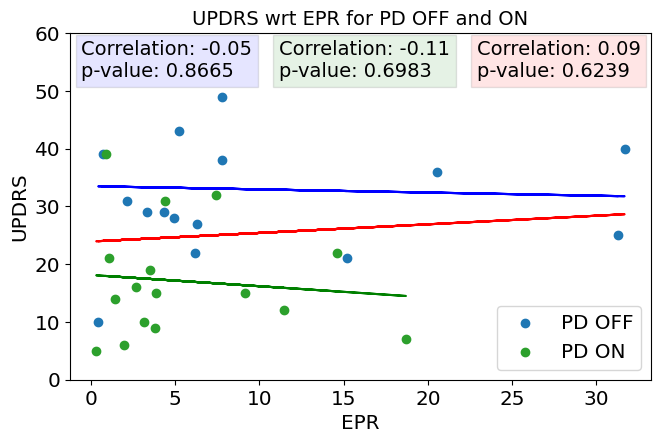

In [ ]:
x = sigma_off
y = updrs_off

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# Calculate the fitted values
y_fit = intercept + slope * x
# Calculate the confidence interval for the fit
y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

print(pearsonr(x, y))

# Plot the data
fig, ax = plt.subplots(figsize=figsize)
plt.scatter(x, y, color=matplot_colors[0], label='PD OFF')
plt.plot(x, y_fit, color='blue')

# Add correlation coefficient and p-value to the plot
plt.text(0.02, 0.98, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='blue', alpha=0.1))

x = sigma_on
y = updrs_on

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# Calculate the fitted values
y_fit = intercept + slope * x
# Calculate the confidence interval for the fit
y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

print(pearsonr(x, y))

# Plot the data
#fig, ax = plt.subplots(figsize=figsize)
plt.scatter(x, y, color=matplot_colors[2], label='PD ON')
plt.plot(x, y_fit, color='green')

# Add correlation coefficient and p-value to the plot
plt.text(0.36, 0.98, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='green', alpha=0.1))


x = np.hstack((sigma_off,sigma_on))
y = np.hstack((updrs_off,updrs_on))
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x,y)
# Calculate the fitted values
y_fit = intercept + slope * x
plt.plot(x, y_fit, color='red')

# Add correlation coefficient and p-value to the plot
plt.text(0.70, 0.98, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='red', alpha=0.1))

plt.xlabel(r'EPR')
plt.ylabel('UPDRS')
plt.title(r'UPDRS wrt EPR for PD OFF and ON', fontsize=14)
plt.legend(loc='lower right')
plt.ylim((0,60))
fig.savefig(os.path.join(save_manuscript_folder, 'EPR_vs_UPDRS_PD_ON_and_OFF.pdf'), bbox_inches='tight')
plt.show()

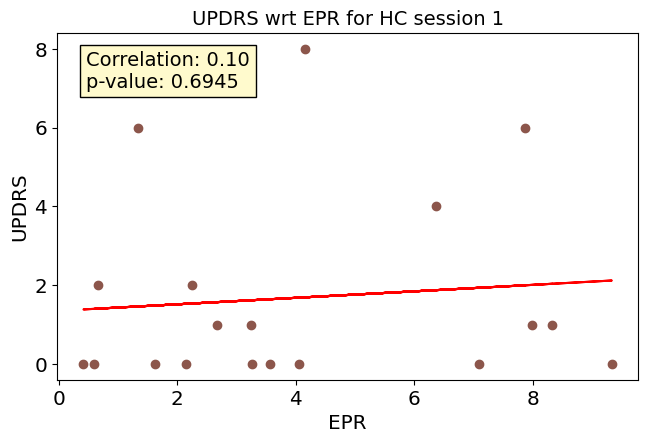

In [ ]:
sigma_off = data_mean[0]
#sigma_on = data_mean[3]
updrs_off = data['HC ses1']['UPDRS']
x = sigma_off
y = updrs_off

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# Calculate the fitted values
y_fit = intercept + slope * x
# Calculate the confidence interval for the fit
y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot the data
fig, ax = plt.subplots(figsize=figsize)
plt.scatter(x, y, color=matplot_colors[5], label='Data points')
plt.plot(x, y_fit, color='red', label='Linear fit')

# Shade the area within the confidence interval
#plt.fill_between(x, y_fit - 1.96 * y_err, y_fit + 1.96 * y_err, color='gray', alpha=0.4, label='95% Confidence Interval')

# Add correlation coefficient and p-value to the plot
plt.text(0.05, 0.95, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='#FFFACD', alpha=1))

plt.xlabel(r'EPR')
plt.ylabel('UPDRS')
plt.title(r'UPDRS wrt EPR for HC session 1', fontsize=14)
fig.savefig(os.path.join(save_manuscript_folder, 'EPR_vs_UPDRS_HC.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
list_corr = []
data_relative_on_off = {}
for region in data['HC ses1'].columns[:-8]:
    sigma_off = data['HC ses1'][region]
    data_relative_on_off[region]=sigma_off
    list_corr.append(pearsonr(data_relative_on_off[region], y))
    #list_corr.append(pearsonr(sigma_on, updrs_on))
    #list_corr.append(spearmanr((sigma_off-sigma_on)/(sigma_on+sigma_off), (updrs_off - updrs_on)/(updrs_on+updrs_off)))

data_relative_on_off['UPDRS'] = y
data_relative_on_off = pd.DataFrame(data_relative_on_off)

df_corr_updrs_sigma = {}
df_corr_updrs_sigma['region'] = [region_acronym_to_full[region] for region in data['HC ses1'].columns[:-8]]
df_corr_updrs_sigma['correlation'] = np.array(list_corr)[:,0]
df_corr_updrs_sigma['p-value'] = np.array(list_corr)[:,1]
df_corr_updrs_sigma = pd.DataFrame(df_corr_updrs_sigma)
df_corr_updrs_sigma.sort_values(by='p-value')

region  correlation   p-value
15                        Superior Parietal Cortex-lh     0.425865  0.069069
20                         Inferior Frontal Cortex-lh    -0.364990  0.124411
37                        Superior Parietal Cortex-rh     0.359674  0.130409
38                        Inferior Parietal Cortex-rh     0.349201  0.142814
11            Insular and Frontal Opercular Cortex-lh    -0.342030  0.151768
5                   Somatosensory and Motor Cortex-lh     0.341434  0.152529
16                        Inferior Parietal Cortex-lh     0.315080  0.188869
27                  Somatosensory and Motor Cortex-rh     0.306574  0.201739
19                Orbital and Polar Frontal Cortex-lh    -0.285500  0.236080
41                         Inferior Frontal Cortex-rh    -0.283203  0.240038
24                     Dorsal Stream Visual Cortex-rh     0.265226  0.272462
40  Anterior Cingulate and Medial Prefrontal Corte...    -0.258518  0.285226
7                                  Premotor Cortex-lh     0.251659  0.298650
34                          Medial Temporal Cortex-rh    -0.247281  0.307416
6     Paracentral Lobular and Mid Cingulate Cortex-lh     0.226119  0.351930
36              Temporo-Parieto-Occipital Junction-rh     0.208663  0.391287
26        MT+ Complex and Neighboring Visual Areas-rh     0.199257  0.413456
12                          Medial Temporal Cortex-lh    -0.197426  0.417850
13                         Lateral Temporal Cortex-lh    -0.183271  0.452639
10                     Auditory Association Cortex-lh    -0.178552  0.464558
39                      Posterior Cingulate Cortex-rh     0.178346  0.465081
18  Anterior Cingulate and Medial Prefrontal Corte...    -0.177387  0.467524
31                           Early Auditory Cortex-rh     0.177227  0.467933
29                                 Premotor Cortex-rh     0.172171  0.480924
21                  DorsoLateral Prefrontal Cortex-lh    -0.167775  0.492360
30                      Posterior Opercular Cortex-rh     0.158423  0.517126
42                  DorsoLateral Prefrontal Cortex-rh    -0.157303  0.520131
2                      Dorsal Stream Visual Cortex-lh     0.151477  0.535894
17                      Posterior Cingulate Cortex-lh     0.141067  0.564584
22                      Primary Visual Cortex (V1)-rh     0.138805  0.570907
35                         Lateral Temporal Cortex-rh    -0.116908  0.633621
3                     Ventral Stream Visual Cortex-lh    -0.106777  0.663503
33            Insular and Frontal Opercular Cortex-rh    -0.103621  0.672915
28    Paracentral Lobular and Mid Cingulate Cortex-rh     0.100220  0.683111
8                       Posterior Opercular Cortex-lh     0.093188  0.704356
23                             Early Visual Cortex-rh     0.074047  0.763212
0                       Primary Visual Cortex (V1)-lh    -0.070391  0.774610
1                              Early Visual Cortex-lh    -0.069966  0.775936
14              Temporo-Parieto-Occipital Junction-lh     0.068846  0.779439
9                            Early Auditory Cortex-lh    -0.038793  0.874715
32                     Auditory Association Cortex-rh     0.024588  0.920411
25                    Ventral Stream Visual Cortex-rh     0.019483  0.936899
4         MT+ Complex and Neighboring Visual Areas-lh    -0.010909  0.964647

In [ ]:
info_filename = os.path.join(data_dir, 'updrs_data_filename.csv') # To fill
updrs_info = pd.read_csv(info_filename, delimiter = ';')
updrs_info
df_info

In [115]:
subject_overlap = df_info[~df_info['LEDD'].isin(['MISSING']) & ~df_info['LEDD'].isna() & df_info['MEG_ID'].isin(data['PD OFF']['subject'])]['MEG_ID']
# Compute mean and std for each subject
data_mean_LEDD = []
data_std_LEDD = []

for group in group_list:
    # Explicit column selection
    data_mean_LEDD.append(data[group][data[group]['subject'].isin(subject_overlap)].iloc[:,:-8].mean(axis=1))
    data_std_LEDD.append(data[group][data[group]['subject'].isin(subject_overlap)].iloc[:,:-8].std(axis=1))

updrs_off_LEDD = data['PD OFF'][data['PD OFF']['subject'].isin(subject_overlap)]['UPDRS']
updrs_on_LEDD = data['PD ON'][data['PD ON']['subject'].isin(subject_overlap)]['UPDRS']


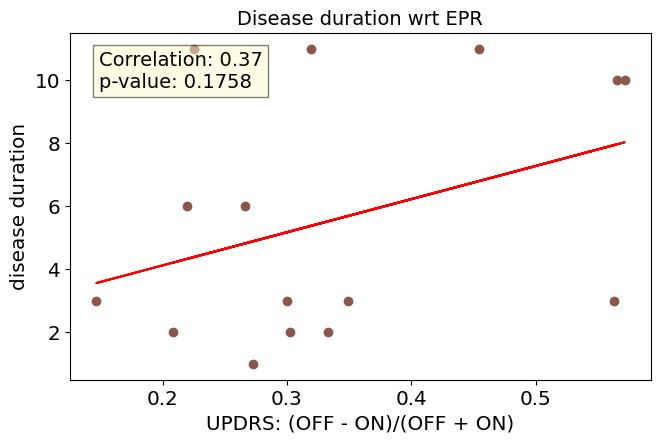

In [ ]:
sigma_off = data_mean_LEDD[2]
sigma_on = data_mean_LEDD[3]
x = (updrs_off_LEDD - updrs_on_LEDD)/(updrs_off_LEDD + updrs_on_LEDD)
y = df_info[df_info['MEG_ID'].isin(subject_overlap)]['disease_dur']
y = [float(item) for item in y.tolist()]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# Calculate the fitted values
y_fit = intercept + slope * x
# Calculate the confidence interval for the fit
y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot the data
fig, ax = plt.subplots(figsize=figsize)
plt.scatter(x, y, color=matplot_colors[5], label='Data points')
plt.plot(x, y_fit, color='red', label='Linear fit')

# Add correlation coefficient and p-value to the plot
plt.text(0.05, 0.95, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='#FFFACD', alpha=.5))

plt.xlabel(r'UPDRS: (OFF - ON)/(OFF + ON)')
plt.ylabel('disease duration')
plt.title(r'Disease duration wrt EPR', fontsize=14)
#fig.savefig(os.path.join(save_manuscript_folder, 'EPR_vs_UPDRS_PD_OFF_to_ON.pdf'), bbox_inches='tight')
plt.show()

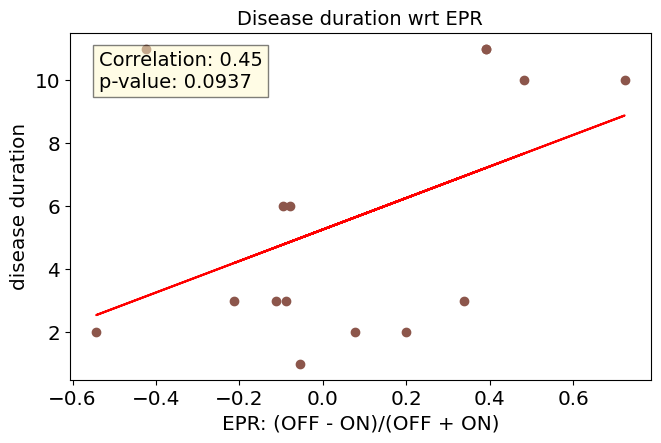

In [ ]:
sigma_off = data_mean_LEDD[2]
sigma_on = data_mean_LEDD[3]
x = (sigma_off - sigma_on)/(sigma_off + sigma_on)
y = df_info[df_info['MEG_ID'].isin(subject_overlap)]['disease_dur']
y = [float(item) for item in y.tolist()]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# Calculate the fitted values
y_fit = intercept + slope * x
# Calculate the confidence interval for the fit
y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot the data
fig, ax = plt.subplots(figsize=figsize)
plt.scatter(x, y, color=matplot_colors[5], label='Data points')
plt.plot(x, y_fit, color='red', label='Linear fit')

# Add correlation coefficient and p-value to the plot
plt.text(0.05, 0.95, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='#FFFACD', alpha=.5))

plt.xlabel(r'EPR: (OFF - ON)/(OFF + ON)')
plt.ylabel('disease duration')
plt.title(r'Disease duration wrt EPR', fontsize=14)
fig.savefig(os.path.join(save_manuscript_folder, 'EPR_vs_disease-dur_PD_OFF_to_ON.pdf'), bbox_inches='tight')
plt.show()

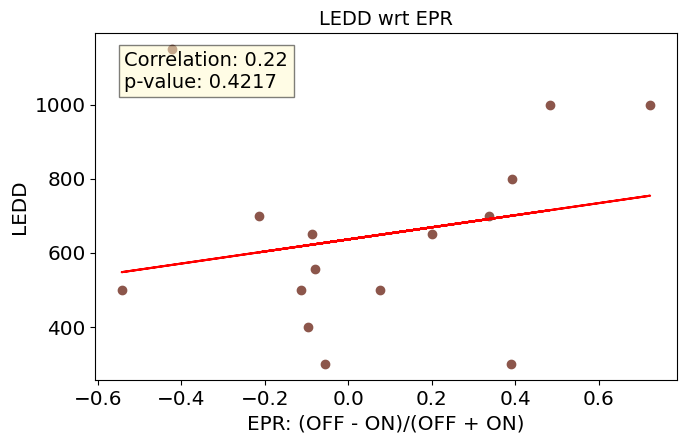

In [ ]:
sigma_off = data_mean_LEDD[2]
sigma_on = data_mean_LEDD[3]
x = (sigma_off - sigma_on)/(sigma_off + sigma_on)
y = df_info[df_info['MEG_ID'].isin(subject_overlap)]['LEDD']
y = [float(item) for item in y.tolist()]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# Calculate the fitted values
y_fit = intercept + slope * x
# Calculate the confidence interval for the fit
y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot the data
fig, ax = plt.subplots(figsize=figsize)
plt.scatter(x, y, color=matplot_colors[5], label='Data points')
plt.plot(x, y_fit, color='red', label='Linear fit')

# Add correlation coefficient and p-value to the plot
plt.text(0.05, 0.95, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='#FFFACD', alpha=.5))

plt.xlabel(r'EPR: (OFF - ON)/(OFF + ON)')
plt.ylabel('LEDD')
plt.title(r'LEDD wrt EPR', fontsize=14)
fig.savefig(os.path.join(save_manuscript_folder, 'EPR_vs_LEDD_PD_OFF_to_ON.pdf'), bbox_inches='tight')
plt.show()

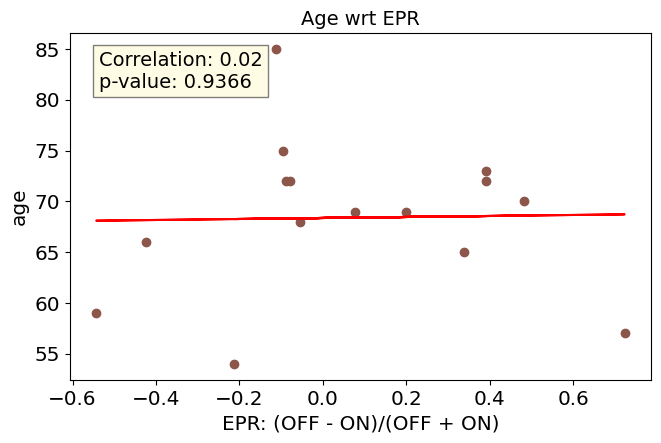

In [ ]:
sigma_off = data_mean_LEDD[2]
sigma_on = data_mean_LEDD[3]
x = (sigma_off - sigma_on)/(sigma_off + sigma_on)
y = df_info[df_info['MEG_ID'].isin(subject_overlap)]['age']
y = [float(item) for item in y.tolist()]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# Calculate the fitted values
y_fit = intercept + slope * x
# Calculate the confidence interval for the fit
y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot the data
fig, ax = plt.subplots(figsize=figsize)
plt.scatter(x, y, color=matplot_colors[5], label='Data points')
plt.plot(x, y_fit, color='red', label='Linear fit')

# Add correlation coefficient and p-value to the plot
plt.text(0.05, 0.95, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='#FFFACD', alpha=.5))

plt.xlabel(r'EPR: (OFF - ON)/(OFF + ON)')
plt.ylabel('age')
plt.title(r'Age wrt EPR', fontsize=14)
fig.savefig(os.path.join(save_manuscript_folder, 'EPR_vs_age_PD_OFF_to_ON.pdf'), bbox_inches='tight')
plt.show()

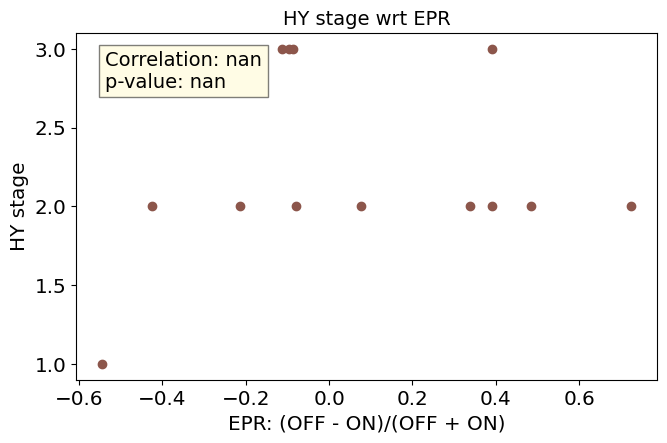

In [ ]:
sigma_off = data_mean_LEDD[2]
sigma_on = data_mean_LEDD[3]
x = (sigma_off - sigma_on)/(sigma_off + sigma_on)
y = df_info[df_info['MEG_ID'].isin(subject_overlap)]['HY_stage']
y = [float(item) for item in y.tolist()]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# Calculate the fitted values
y_fit = intercept + slope * x
# Calculate the confidence interval for the fit
y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot the data
fig, ax = plt.subplots(figsize=figsize)
plt.scatter(x, y, color=matplot_colors[5], label='Data points')
plt.plot(x, y_fit, color='red', label='Linear fit')

# Add correlation coefficient and p-value to the plot
plt.text(0.05, 0.95, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='#FFFACD', alpha=.5))

plt.xlabel(r'EPR: (OFF - ON)/(OFF + ON)')
plt.ylabel('HY stage')
plt.title(r'HY stage wrt EPR', fontsize=14)
fig.savefig(os.path.join(save_manuscript_folder, 'EPR_vs_HY_PD_OFF_to_ON.pdf'), bbox_inches='tight')
plt.show()

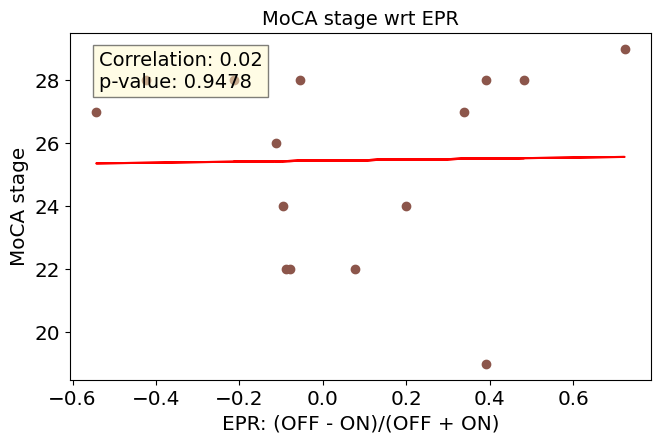

In [ ]:
sigma_off = data_mean_LEDD[2]
sigma_on = data_mean_LEDD[3]
x = (sigma_off - sigma_on)/(sigma_off + sigma_on)
y = df_info[df_info['MEG_ID'].isin(subject_overlap)]['MoCA']
y = [float(item) for item in y.tolist()]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# Calculate the fitted values
y_fit = intercept + slope * x
# Calculate the confidence interval for the fit
y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot the data
fig, ax = plt.subplots(figsize=figsize)
plt.scatter(x, y, color=matplot_colors[5], label='Data points')
plt.plot(x, y_fit, color='red', label='Linear fit')

# Add correlation coefficient and p-value to the plot
plt.text(0.05, 0.95, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='#FFFACD', alpha=0.5))

plt.xlabel(r'EPR: (OFF - ON)/(OFF + ON)')
plt.ylabel('MoCA stage')
plt.title(r'MoCA stage wrt EPR', fontsize=14)
fig.savefig(os.path.join(save_manuscript_folder, 'EPR_vs_MoCA_PD_OFF_to_ON.pdf'), bbox_inches='tight')
plt.show()

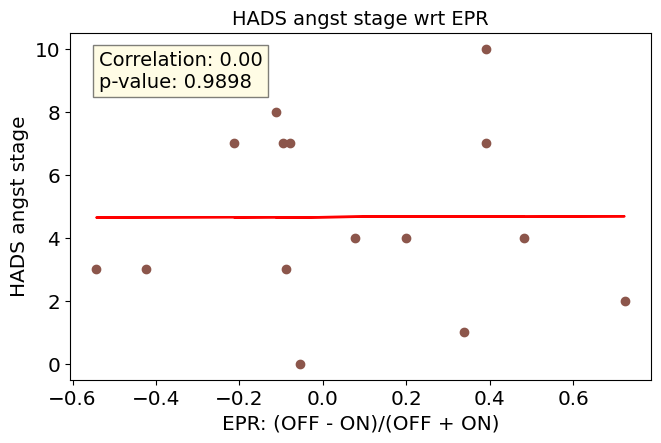

In [ ]:
sigma_off = data_mean_LEDD[2]
sigma_on = data_mean_LEDD[3]
x = (sigma_off - sigma_on)/(sigma_off + sigma_on)
y = df_info[df_info['MEG_ID'].isin(subject_overlap)]['HADS_angst']
y = [float(item) for item in y.tolist()]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# Calculate the fitted values
y_fit = intercept + slope * x
# Calculate the confidence interval for the fit
y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot the data
fig, ax = plt.subplots(figsize=figsize)
plt.scatter(x, y, color=matplot_colors[5], label='Data points')
plt.plot(x, y_fit, color='red', label='Linear fit')

# Add correlation coefficient and p-value to the plot
plt.text(0.05, 0.95, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='#FFFACD', alpha=0.5))

plt.xlabel(r'EPR: (OFF - ON)/(OFF + ON)')
plt.ylabel('HADS angst stage')
plt.title(r'HADS angst stage wrt EPR', fontsize=14)
fig.savefig(os.path.join(save_manuscript_folder, 'EPR_vs_HADS-angst_PD_OFF_to_ON.pdf'), bbox_inches='tight')
plt.show()

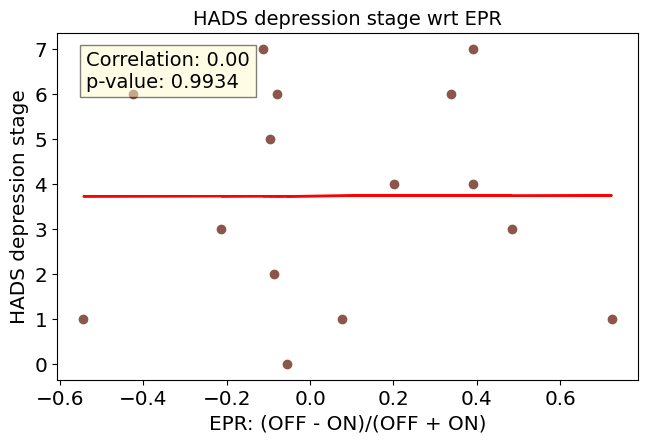

In [ ]:
sigma_off = data_mean_LEDD[2]
sigma_on = data_mean_LEDD[3]
x = (sigma_off - sigma_on)/(sigma_off + sigma_on)
y = df_info[df_info['MEG_ID'].isin(subject_overlap)]['HADS_depression']
y = [float(item) for item in y.tolist()]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
# Calculate the fitted values
y_fit = intercept + slope * x
# Calculate the confidence interval for the fit
y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot the data
fig, ax = plt.subplots(figsize=figsize)
plt.scatter(x, y, color=matplot_colors[5], label='Data points')
plt.plot(x, y_fit, color='red', label='Linear fit')

# Add correlation coefficient and p-value to the plot
plt.text(0.05, 0.95, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='#FFFACD', alpha=0.5))

plt.xlabel(r'EPR: (OFF - ON)/(OFF + ON)')
plt.ylabel('HADS depression stage')
plt.title(r'HADS depression stage wrt EPR', fontsize=14)
fig.savefig(os.path.join(save_manuscript_folder, 'EPR_vs_HADS-dep_PD_OFF_to_ON.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
info_filename = os.path.join(data_dir, 'updrs_data.csv')
updrs_info = pd.read_csv(info_filename, delimiter = ';')
subject_overlap = updrs_info[updrs_info['id'].isin(data['PD OFF']['subject'])]['id']
updrs_info = updrs_info[updrs_info['id'].isin(subject_overlap)]
print(updrs_info)
updrs_info_ses1 = updrs_info[updrs_info['session']==1]
updrs_info_ses2 = updrs_info[updrs_info['session']==2]

PearsonRResult(statistic=np.float64(-0.025296556202575357), pvalue=np.float64(0.9259097378651165))


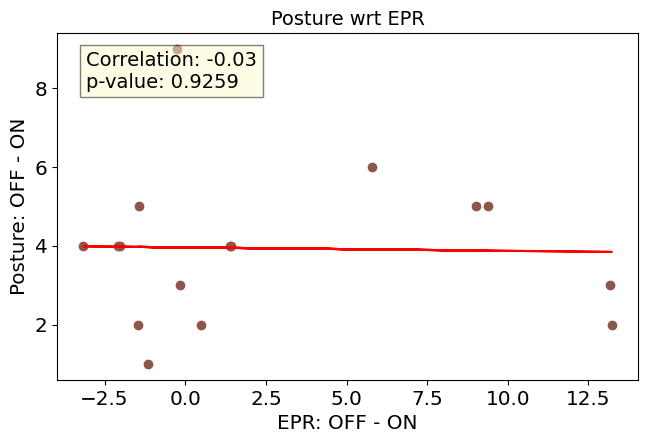

PearsonRResult(statistic=np.float64(0.38787969263163646), pvalue=np.float64(0.1376733000906912))


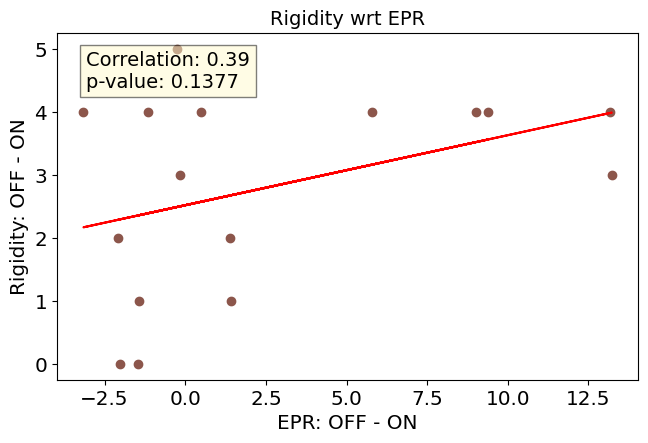

PearsonRResult(statistic=np.float64(0.7318267208495836), pvalue=np.float64(0.0012703674347145245))


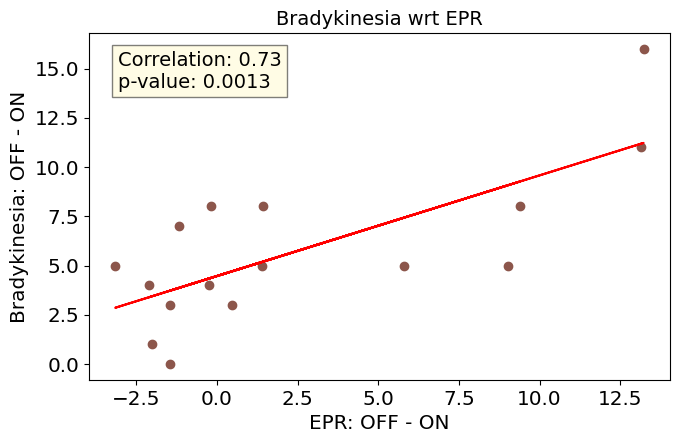

PearsonRResult(statistic=np.float64(0.14182854852347485), pvalue=np.float64(0.6003089303687564))


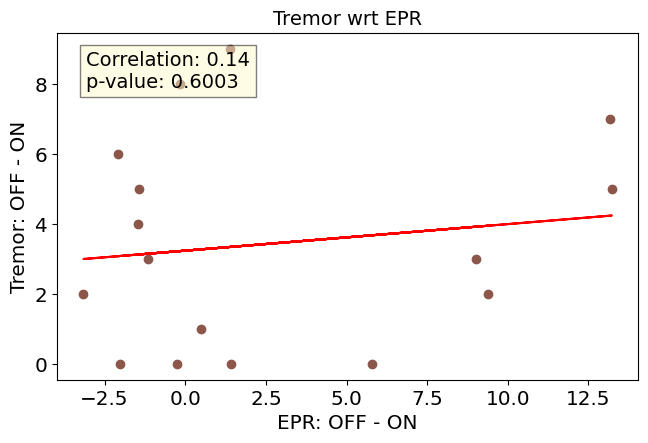

In [ ]:
for score,name_complication in zip([['F1'],['F3'],['F45','F7'],['F6','F2']],['Posture','Rigidity','Bradykinesia','Tremor']):
    updrs_off = sum([np.array(updrs_info_ses1[score_].values.tolist()) for score_ in score])
    updrs_on = sum([np.array(updrs_info_ses2[score_].values.tolist()) for score_ in score])
    z1 = (updrs_off - updrs_on)#/(updrs_off + updrs_on)#updrs_on
    ind_not_null = ~np.isnan(z1)
    y=z1[ind_not_null]
    sigma_off = data_mean[2]
    sigma_on = data_mean[3]
    z2 = (sigma_off - sigma_on)#/(sigma_off + sigma_on)#sigma_on
    x = z2[ind_not_null]
    print(pearsonr(x,y))
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    # Calculate the fitted values
    y_fit = intercept + slope * x
    # Calculate the confidence interval for the fit
    y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    
    # Plot the data
    fig, ax = plt.subplots(figsize=figsize)
    plt.scatter(x, y, color=matplot_colors[5], label='Data points')
    plt.plot(x, y_fit, color='red', label='Linear fit')

    # Add correlation coefficient and p-value to the plot
    plt.text(0.05, 0.95, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
             transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='#FFFACD', alpha=0.5))
    
    plt.xlabel(r'EPR: OFF - ON')
    plt.ylabel(f'{name_complication}: OFF - ON')
    plt.title(f'{name_complication} wrt EPR', fontsize=14)
    fig.savefig(os.path.join(save_manuscript_folder, f'{score}.pdf'), bbox_inches='tight')
    plt.show()

PearsonRResult(statistic=np.float64(-0.20773734215499923), pvalue=np.float64(0.4400996620138525))


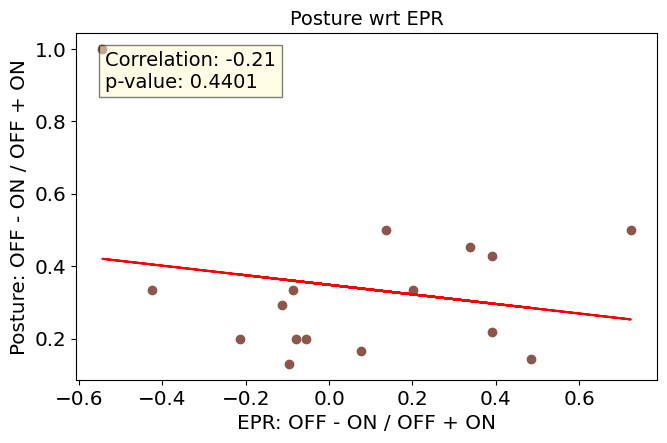

PearsonRResult(statistic=np.float64(0.4216243409963524), pvalue=np.float64(0.1038255980327213))


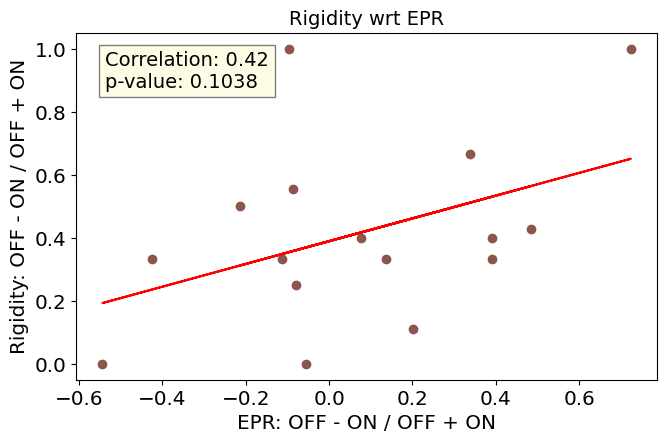

PearsonRResult(statistic=np.float64(0.5435050377430523), pvalue=np.float64(0.029555553156272535))


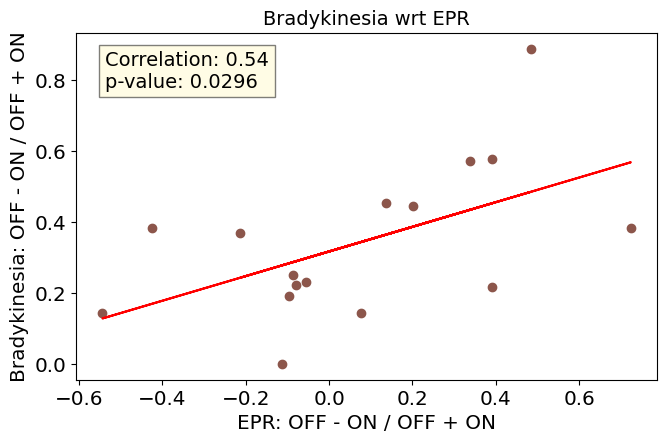

/var/folders/rk/5bdpv8dd7g54x4blppp22lxd28ndpv/T/ipykernel_7899/3668061372.py:4: RuntimeWarning: invalid value encountered in divide
  z1 = (updrs_off - updrs_on)/(updrs_off + updrs_on)#updrs_on


PearsonRResult(statistic=np.float64(0.4072856127827375), pvalue=np.float64(0.13186404273840802))


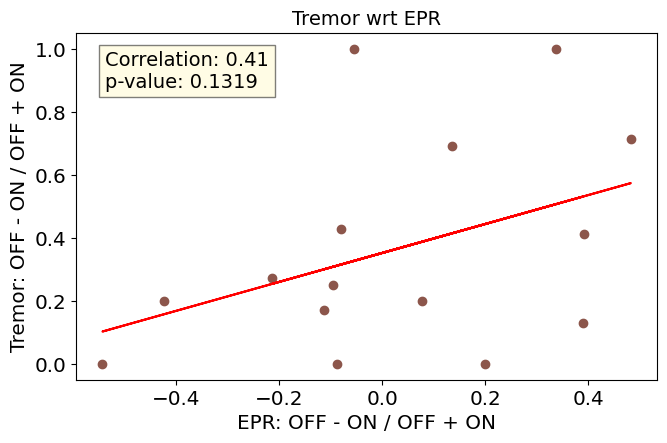

In [ ]:
for score,name_complication in zip([['F1'],['F3'],['F45','F7'],['F6','F2']],['Posture','Rigidity','Bradykinesia','Tremor']):
    updrs_off = sum([np.array(updrs_info_ses1[score_].values.tolist()) for score_ in score])
    updrs_on = sum([np.array(updrs_info_ses2[score_].values.tolist()) for score_ in score])
    z1 = (updrs_off - updrs_on)/(updrs_off + updrs_on)#updrs_on
    ind_not_null = ~np.isnan(z1)
    y=z1[ind_not_null]
    sigma_off = data_mean[2]
    sigma_on = data_mean[3]
    z2 = (sigma_off - sigma_on)/(sigma_off + sigma_on)#sigma_on
    x = z2[ind_not_null]
    print(pearsonr(x,y))
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    # Calculate the fitted values
    y_fit = intercept + slope * x
    # Calculate the confidence interval for the fit
    y_err = std_err * np.sqrt(1/len(x) + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    
    # Plot the data
    fig, ax = plt.subplots(figsize=figsize)
    plt.scatter(x, y, color=matplot_colors[5], label='Data points')
    plt.plot(x, y_fit, color='red', label='Linear fit')

    # Add correlation coefficient and p-value to the plot
    plt.text(0.05, 0.95, f'Correlation: {r_value:.2f}\np-value: {p_value:.4f}',
             transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=dict(facecolor='#FFFACD', alpha=0.5))
    
    plt.xlabel(r'EPR: OFF - ON / OFF + ON')
    plt.ylabel(f'{name_complication}: OFF - ON / OFF + ON')
    plt.title(f'{name_complication} wrt EPR', fontsize=14)
    fig.savefig(os.path.join(save_manuscript_folder, f'{score}.pdf'), bbox_inches='tight')
    plt.show()

In [ ]:
template_subjects_dir = data_dir+"/fs_subjects_dir"
template_subject = 'subject_ID' # To fill

labels_parc = mne.read_labels_from_annot(
    template_subject, parc=parc, subjects_dir=template_subjects_dir, sort=False
)

inds = []
for label,ind_ in zip(labels_parc,range(len(labels_parc))):
    if '???' not in label.name:
        inds.append(ind_)

In [107]:
# Compute mean and std for each subject
data_region_mean = []
data_region_std = []

for group in group_list:
    # Explicit column selection
    data_region_mean.append(data[group].iloc[:,:-8].mean(axis=0))
    data_region_std.append(data[group].iloc[:,:-8].std(axis=0))
control_means = data_region_mean[0]
patient_means = data_region_mean[2]

Using pyvistaqt 3d backend.


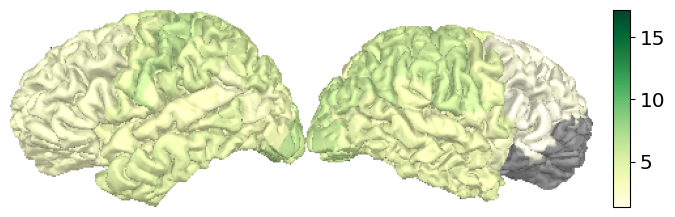

In [ ]:
# Generate empty brain for control
Brain = mne.viz.get_brain_class()
brain_control = Brain(
    template_subject,
    subjects_dir=template_subjects_dir,
    cortex="low_contrast",
    background="white",
    views='lat',
    hemi='split',
    size=(800, 400),
    title='control'
)

regions = data['PD OFF'].columns[:-8]

# add epr values
cmap = matplotlib.colormaps['YlGn']
norm = matplotlib.colors.Normalize(vmin = min(np.min(control_means), np.min(patient_means)), vmax = max(np.max(control_means), np.max(patient_means)))

colors = cmap(norm(control_means).data)
brain_control.remove_labels()
counter = 0
for i,ii in enumerate(inds):
    label = labels_parc[ii]
    if region_full_to_acronym[label.name] in regions:
        brain_control.add_label(label, alpha=1, color=cmap(norm(control_means[counter])))
        counter = counter+1
    
# Dezoom the brain visualization
brain_control.show_view(distance=600)  # Adjust the distance as needed

# screenshots for lateral views
screenshot = brain_control.screenshot()
nonwhite_pix = (screenshot != 255).any(-1)
nonwhite_row = nonwhite_pix.any(1)
nonwhite_col = nonwhite_pix.any(0)
cropped_screenshot_control = screenshot[nonwhite_row][:, nonwhite_col]


fig, ax = plt.subplots(1,1, figsize = (8,4))

ax.imshow(cropped_screenshot_control)

ax.axis("off")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar=fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.ax.yaxis.set_major_formatter(ScalarFormatter())

fig.savefig(os.path.join(save_manuscript_folder, 'brain_vis_EPR_control.pdf'), bbox_inches='tight')

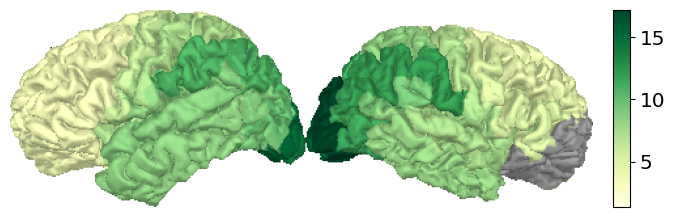

In [ ]:
# Generate empty brain for control
Brain = mne.viz.get_brain_class()
brain_control = Brain(
    template_subject,
    subjects_dir=template_subjects_dir,
    cortex="low_contrast",
    background="white",
    views='lat',
    hemi='split',
    size=(800, 400),
    title='control'
)

regions = data['PD OFF'].columns[:-8]

# add epr values
cmap = matplotlib.colormaps['YlGn']
norm = matplotlib.colors.Normalize(vmin = min(np.min(control_means), np.min(patient_means)), vmax = max(np.max(control_means), np.max(patient_means)))

colors = cmap(norm(control_means).data)
brain_control.remove_labels()
counter = 0
for i,ii in enumerate(inds):
    label = labels_parc[ii]
    if region_full_to_acronym[label.name] in regions:
        brain_control.add_label(label, alpha=1, color=cmap(norm(patient_means[counter])))
        counter = counter+1
    
# Dezoom the brain visualization
brain_control.show_view(distance=600)  # Adjust the distance as needed

# screenshots for lateral views
screenshot = brain_control.screenshot()
nonwhite_pix = (screenshot != 255).any(-1)
nonwhite_row = nonwhite_pix.any(1)
nonwhite_col = nonwhite_pix.any(0)
cropped_screenshot_control = screenshot[nonwhite_row][:, nonwhite_col]


fig, ax = plt.subplots(1,1, figsize = (8,4))

ax.imshow(cropped_screenshot_control)

ax.axis("off")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar=fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.ax.yaxis.set_major_formatter(ScalarFormatter())

fig.savefig(os.path.join(save_manuscript_folder, 'brain_vis_EPR_patient.pdf'), bbox_inches='tight')

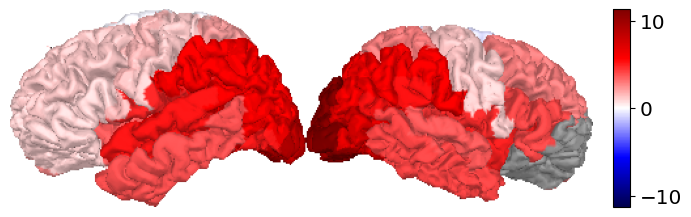

In [ ]:
# Generate empty brain for patient

brain_difference = Brain(
    template_subject,
    subjects_dir=template_subjects_dir,
    cortex="low_contrast",
    background="white",
    views='lat',
    hemi='split',
    size=(800, 400),
    title='difference'
)
brain_difference.show_view(distance=600)  # Adjust the distance as needed


# add epr values
brain_difference.remove_labels()
counter=0
for i,ii in enumerate(inds):
    label = labels_parc[ii]
    if region_full_to_acronym[label.name] in regions:
        brain_difference.add_label(label, alpha=1, color=cmap(norm(patient_means[counter] - control_means[counter])))
        counter = counter+1
    

# screenshots for lateral views
screenshot = brain_difference.screenshot()
nonwhite_pix = (screenshot != 255).any(-1)
nonwhite_row = nonwhite_pix.any(1)
nonwhite_col = nonwhite_pix.any(0)
cropped_screenshot_dif = screenshot[nonwhite_row][:, nonwhite_col]

cmap = matplotlib.colormaps['seismic']
norm = matplotlib.colors.Normalize(vmin = -np.max(np.abs(patient_means.values - control_means.values)), vmax = np.max(np.abs(patient_means.values - control_means.values)))

fig, ax = plt.subplots(1,1, figsize = (8,4))

ax.imshow(cropped_screenshot_dif)

ax.axis("off")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax = cax)

fig.savefig(os.path.join(save_manuscript_folder, 'brain_vis_EPR_diff.pdf'), bbox_inches='tight')